In [1]:
import os
import sys
sys.path.append(os.path.abspath("..")) 

import math
import time
import datetime
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from tcunet import Unet2D
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from torchinfo import summary
import torchprofile

import pickle

torch.manual_seed(23)

scaler = GradScaler()

DTYPE = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "serif"

import scipy.stats as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

Using device: cuda


In [2]:
class CustomLoss(nn.Module):
    def __init__(self, Par):
        super(CustomLoss, self).__init__()
        self.Par = Par

    def forward(self, y_pred, y_true):
        y_true = (y_true - self.Par["out_shift"])/self.Par["out_scale"]
        y_pred = (y_pred - self.Par["out_shift"])/self.Par["out_scale"]
        loss = torch.norm(y_true-y_pred, p=2)/torch.norm(y_true, p=2)
        return loss

class YourDataset(Dataset):
    def __init__(self, x, t, y, transform=None):
        self.x = x
        self.t = t
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x_sample = self.x[idx]
        t_sample = self.t[idx]
        y_sample = self.y[idx]

        if self.transform:
            x_sample, t_sample, y_sample = self.transform(x_sample, t_sample, y_sample)

        return x_sample, t_sample, y_sample


def preprocess(traj_i, traj_o, Par):
    x = sliding_window_view(traj_i[:,:,:,:], window_shape=Par['lf'], axis=1 ).transpose(0,1,4,2,3).reshape(-1,Par['lf'],Par['nx'], Par['ny'])[:, [0,-1]] # BS, 2, nx, ny
    y = sliding_window_view(traj_o[:,:,:,:], window_shape=Par['lf'], axis=1 ).transpose(0,1,4,2,3).reshape(-1,Par['lf'],Par['nx'], Par['ny'])            # BS, lf, nx, ny
    t = np.linspace(0,1,Par['lf']).reshape(-1,1)

    nt = y.shape[1]
    n_samples = y.shape[0]

    t = np.tile(t, [n_samples,1]).reshape(-1,)              
    x = np.repeat(x,nt, axis=0)                  
    y = y.reshape(y.shape[0]*y.shape[1],1,y.shape[2],y.shape[3])  


    print('x: ', x.shape)
    print('y: ', y.shape)
    print('t: ', t.shape)
    print()
    return x,y,t

def combined_scheduler(optimizer, total_epochs, warmup_epochs, last_epoch=-1):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch + 1) / warmup_epochs
        else:
            return 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))

    return LambdaLR(optimizer, lr_lambda, last_epoch)

def make_images(true, pred, epoch):
    sample_id = -2
    t_id = 0

    CMAP = "gray"
    VMIN = 0
    VMAX = 255


    T = true[sample_id, t_id].detach().cpu().numpy()*256
    P = pred[sample_id, t_id].detach().cpu().numpy()*256

    fig, axes = plt.subplots(1,2, figsize=(20,5))
    axes[0].imshow(T, cmap=CMAP, vmin=VMIN, vmax=VMAX)
    axes[0].set_title("True")
    axes[1].imshow(P, cmap=CMAP, vmin=VMIN, vmax=VMAX)
    axes[1].set_title("Pred")

    plt.tight_layout()


    fig.suptitle(f"Epoch: {epoch}", fontsize=22, y=1.2)
    plt.savefig(f"images/{epoch}.png", dpi=150, bbox_inches='tight')
    plt.close()



In [3]:
begin_time = time.time()
traj_i = np.load(f"../../data/lr8_data.npy").astype(np.float32)/256 #[nt, nx, ny]
traj_i = np.expand_dims(traj_i, axis=0) #[1, nt, nx, ny]
traj_o = np.load(f"../../data/hr_data.npy").astype(np.float32)/256 #[nt, nx, ny]
traj_o = np.expand_dims(traj_o, axis=0) #[1, nt, nx, ny]

print(f"traj_i: {traj_i.shape}")
print(f"traj_o: {traj_o.shape}")

print(f"Data Loading Time: {time.time() - begin_time:.1f}s")


nsamples = traj_i.shape[1]
idx1 = int(0.8*nsamples)
idx2 = int(0.9*nsamples)

print(idx1, idx2)

traj_i_train = traj_i[:, :idx1]
traj_i_val   = traj_i[:, idx1:idx2]
traj_i_test  = traj_i[:, idx2:]

traj_o_train = traj_o[:, :idx1]
traj_o_val   = traj_o[:, idx1:idx2]
traj_o_test  = traj_o[:, idx2:]

Par = {}
Par['nx'] = traj_i_train.shape[2]
Par['ny'] = traj_i_train.shape[3]
Par['nf'] = 1
Par['d_emb'] = 128

Par['lb'] = 2
Par['lf'] = 4+1

Par['num_epochs'] = 50 #50

begin_time = time.time()
print('\nTrain Dataset')
x_train, y_train, t_train = preprocess(traj_i_train, traj_o_train, Par)
print('\nValidation Dataset')
x_val, y_val, t_val  = preprocess(traj_i_val, traj_o_val, Par)
print('\nTest Dataset')
x_test, y_test, t_test  = preprocess(traj_i_test, traj_o_test, Par)
print(f"Data Preprocess Time: {time.time() - begin_time:.1f}s")


t_min = np.min(t_train)
t_max = np.max(t_train)

Par['inp_scale'] = np.max(x_train) - np.min(x_train)
Par['inp_shift'] = np.min(x_train)
Par['out_scale'] = np.max(y_train) - np.min(y_train)
Par['out_shift'] = np.min(y_train)
Par['t_shift']   = t_min
Par['t_scale']   = t_max - t_min

with open('Par.pkl', 'wb') as f:
    pickle.dump(Par, f)


# Create custom datasets
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
t_train_tensor = torch.tensor(t_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_val_tensor   = torch.tensor(x_val,   dtype=torch.float32)
t_val_tensor   = torch.tensor(t_val,   dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val,   dtype=torch.float32)

x_test_tensor  = torch.tensor(x_test,  dtype=torch.float32)
t_test_tensor  = torch.tensor(t_test,  dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32)

train_dataset = YourDataset(x_train_tensor, t_train_tensor, y_train_tensor)
val_dataset = YourDataset(x_val_tensor, t_val_tensor, y_val_tensor)
test_dataset = YourDataset(x_test_tensor, t_test_tensor, y_test_tensor)

# Define data loaders
train_batch_size = 20
val_batch_size   = 20
test_batch_size  = 20
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

traj_i: (1, 1000, 128, 256)
traj_o: (1, 1000, 128, 256)
Data Loading Time: 1.2s

Train Dataset
x:  (3980, 2, 128, 256)
y:  (3980, 1, 128, 256)
t:  (3980,)


Validation Dataset
x:  (480, 2, 128, 256)
y:  (480, 1, 128, 256)
t:  (480,)


Test Dataset
x:  (480, 2, 128, 256)
y:  (480, 1, 128, 256)
t:  (480,)

Data Preprocess Time: 4.5s


In [4]:
noadv = Unet2D(dim=16, Par=Par, dim_mults=(1, 2, 4, 8)).to(device).to(torch.float32)

path_model = f'saved_models/best_model.pth'
noadv.load_state_dict(torch.load(path_model))

print(summary(noadv, input_size=((1,)+x_train.shape[1:], (1,)) ) )

dummy_x = x_train_tensor[0:1].to(device)
dummy_t = t_train_tensor[0:1].to(device)
dummy_input = (dummy_x, dummy_t)

# Profile the model
flops = 2*torchprofile.profile_macs(noadv, dummy_input)
print(f"FLOPs: {flops:.2e}")

# Define loss function and optimizer
criterion = CustomLoss(Par)

Layer (type:depth-idx)                                  Output Shape              Param #
Unet2D                                                  [1, 1, 128, 256]          --
├─Conv2d: 1-1                                           [1, 16, 128, 256]         3,152
├─Sequential: 1-2                                       [1, 64]                   --
│    └─SinusoidalPosEmb: 2-1                            [1, 16]                   --
│    └─Linear: 2-2                                      [1, 64]                   1,088
│    └─GELU: 2-3                                        [1, 64]                   --
│    └─Linear: 2-4                                      [1, 64]                   4,160
├─ModuleList: 1-3                                       --                        --
│    └─ModuleList: 2-5                                  --                        --
│    │    └─ResnetBlock: 3-1                            [1, 16, 128, 256]         6,784
│    │    └─ResnetBlock: 3-2                    

/oscar/home/voommen/apps/torch_env/lib64/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::lift_fresh". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/oscar/home/voommen/apps/torch_env/lib64/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::reshape". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/oscar/home/voommen/apps/torch_env/lib64/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::repeat". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/oscar/home/voommen/apps/torch_env/lib64/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/oscar/home/voommen/apps/torch_env/lib64/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::arange". Skipped.
  wa

In [5]:
no = Unet2D(dim=16, Par=Par, dim_mults=(1, 2, 4, 8)).to(device).to(torch.float32)


path_model = f'../models/best_model.pt'
no.load_state_dict(torch.load(path_model))

print(summary(noadv, input_size=((1,)+x_train.shape[1:], (1,)) ) )

# Adjust the dimensions as per your model's input size
dummy_x = x_train_tensor[0:1].to(device)
dummy_t = t_train_tensor[0:1].to(device)
dummy_input = (dummy_x, dummy_t)

# Profile the model
flops = torchprofile.profile_macs(no, dummy_input)
print(f"FLOPs: {flops:.2e}")

# Define loss function and optimizer
criterion = CustomLoss(Par)

Layer (type:depth-idx)                                  Output Shape              Param #
Unet2D                                                  [1, 1, 128, 256]          --
├─Conv2d: 1-1                                           [1, 16, 128, 256]         3,152
├─Sequential: 1-2                                       [1, 64]                   --
│    └─SinusoidalPosEmb: 2-1                            [1, 16]                   --
│    └─Linear: 2-2                                      [1, 64]                   1,088
│    └─GELU: 2-3                                        [1, 64]                   --
│    └─Linear: 2-4                                      [1, 64]                   4,160
├─ModuleList: 1-3                                       --                        --
│    └─ModuleList: 2-5                                  --                        --
│    │    └─ResnetBlock: 3-1                            [1, 16, 128, 256]         6,784
│    │    └─ResnetBlock: 3-2                    

/oscar/home/voommen/apps/torch_env/lib64/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::lift_fresh". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/oscar/home/voommen/apps/torch_env/lib64/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::reshape". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/oscar/home/voommen/apps/torch_env/lib64/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::repeat". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/oscar/home/voommen/apps/torch_env/lib64/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/oscar/home/voommen/apps/torch_env/lib64/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::arange". Skipped.
  wa

In [6]:
noadv.named_parameters()

<generator object Module.named_parameters at 0x7f216833f3c0>

In [7]:
no_name_ls = []
noadv_name_ls = []
no_param_ls = []
noadv_param_ls = []

for (no_name, no_param), (noadv_name, noadv_param) in zip(no.named_parameters(), noadv.named_parameters()):
    if 'weight' in no_name and no_param.dim() >= 2:

        no_name_ls.append(no_name)
        no_param_ls.append(no_param)
        noadv_name_ls.append(noadv_name)
        noadv_param_ls.append(noadv_param)


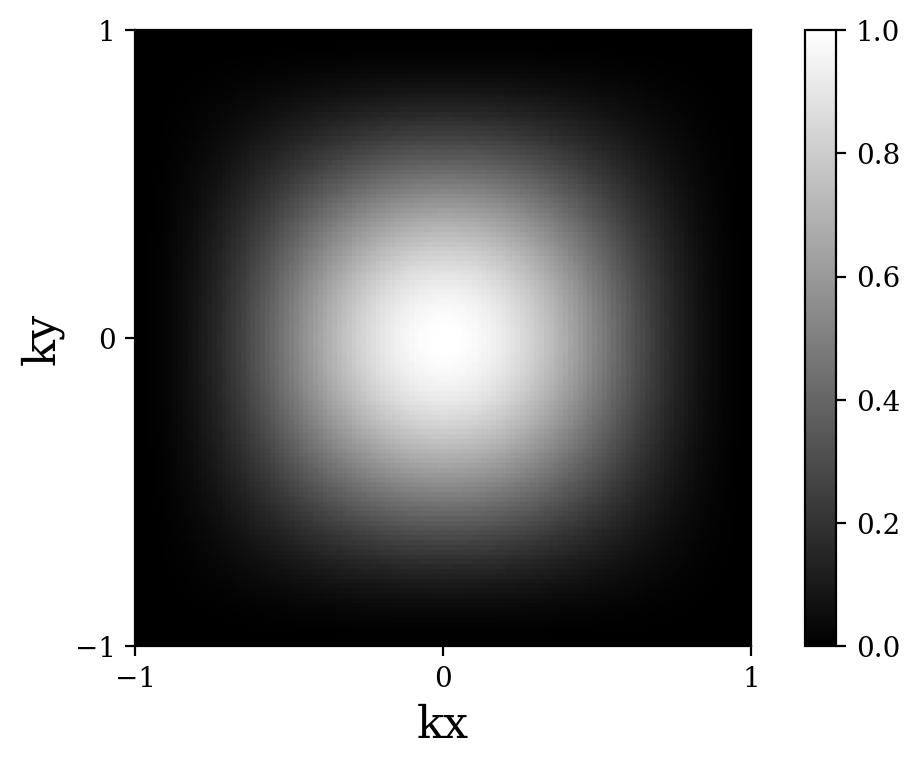

In [19]:
g = torch.tensor([[1, 2, 1],
                  [2, 4, 2],
                  [1, 2, 1]], dtype=torch.float32)
g /= g.sum()
fft_g = torch.abs(torch.fft.fftshift(torch.fft.fft2(g, s=(128,128))))

fig = plt.figure(figsize=(7,4))
plt.imshow(fft_g.numpy(), extent=[-1, 1, -1, 1], cmap='gray')
plt.xticks([-1, 0, 1], fontsize=10)
plt.yticks([-1, 0, 1],fontsize=10)
plt.xlabel("kx", fontsize=16)
plt.ylabel("ky", fontsize=16)
plt.colorbar() 
plt.show()

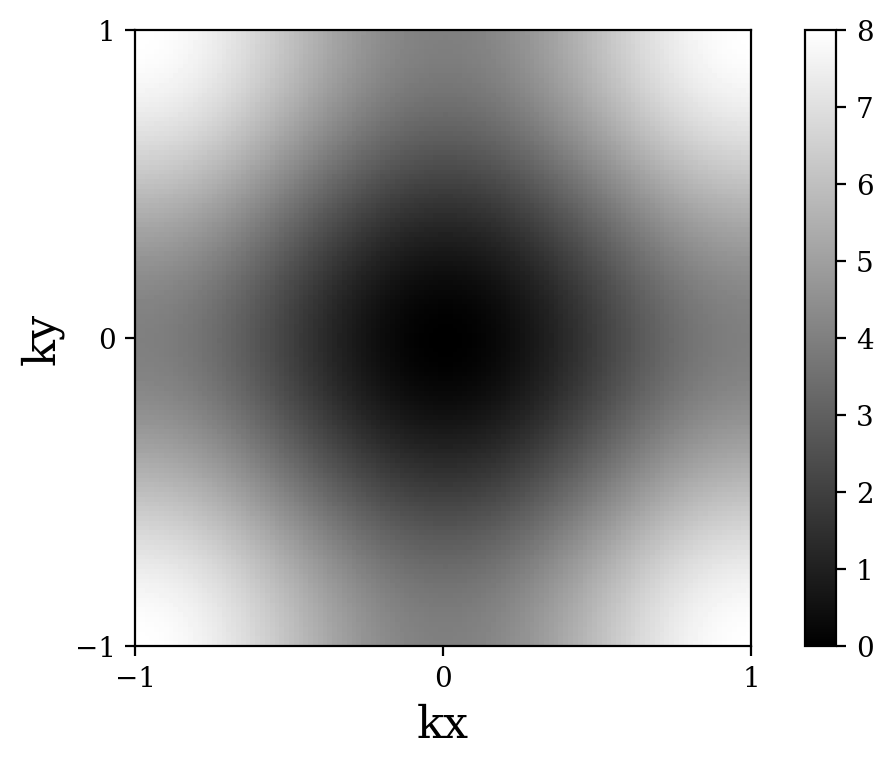

In [20]:
l = torch.tensor([[0, -1, 0],
                  [-1, 4, -1],
                  [0, -1, 0]], dtype=torch.float32)
fft_l = torch.abs(torch.fft.fftshift(torch.fft.fft2(l, s=(128,128))))

fig = plt.figure(figsize=(7,4))
plt.imshow(fft_l.numpy(), extent=[-1, 1, -1, 1], cmap='gray')
plt.xticks([-1, 0, 1], fontsize=10)
plt.yticks([-1, 0, 1],fontsize=10)
plt.xlabel("kx", fontsize=16)
plt.ylabel("ky", fontsize=16)
# plt.title("Low Pass Filter")
plt.colorbar() 
plt.show()

In [21]:
no_w = no_param_ls[0].reshape(-1,7,7)
noadv_w = noadv_param_ls[0].reshape(-1,7,7)

print(no_w)
print(noadv_w)

tensor([[[-0.0073, -0.0272, -0.0082,  ...,  0.0684, -0.0528, -0.0265],
         [ 0.0620,  0.0144, -0.0510,  ..., -0.0549,  0.0429,  0.0095],
         [-0.0030, -0.0365, -0.0379,  ..., -0.0047, -0.0337,  0.0204],
         ...,
         [ 0.0645, -0.0266, -0.0006,  ..., -0.0197,  0.0272,  0.0251],
         [-0.0420, -0.0038, -0.0537,  ...,  0.0414,  0.0099, -0.0574],
         [-0.0262,  0.0441, -0.0288,  ..., -0.0497, -0.0089, -0.0416]],

        [[-0.0522, -0.0326, -0.0213,  ...,  0.0650,  0.0321,  0.0431],
         [ 0.0268, -0.0302,  0.0324,  ..., -0.0488, -0.0118,  0.0382],
         [-0.0070,  0.0041,  0.0210,  ..., -0.0556, -0.0416,  0.0347],
         ...,
         [ 0.0562, -0.0315, -0.0094,  ...,  0.0380, -0.0670, -0.0043],
         [ 0.0574,  0.0653,  0.0381,  ...,  0.0176, -0.0496,  0.0119],
         [-0.0327,  0.0015, -0.0625,  ..., -0.0175,  0.0172, -0.0586]],

        [[ 0.0256,  0.0247,  0.0452,  ..., -0.0024, -0.0243, -0.0560],
         [-0.0090,  0.0577,  0.0671,  ...,  0

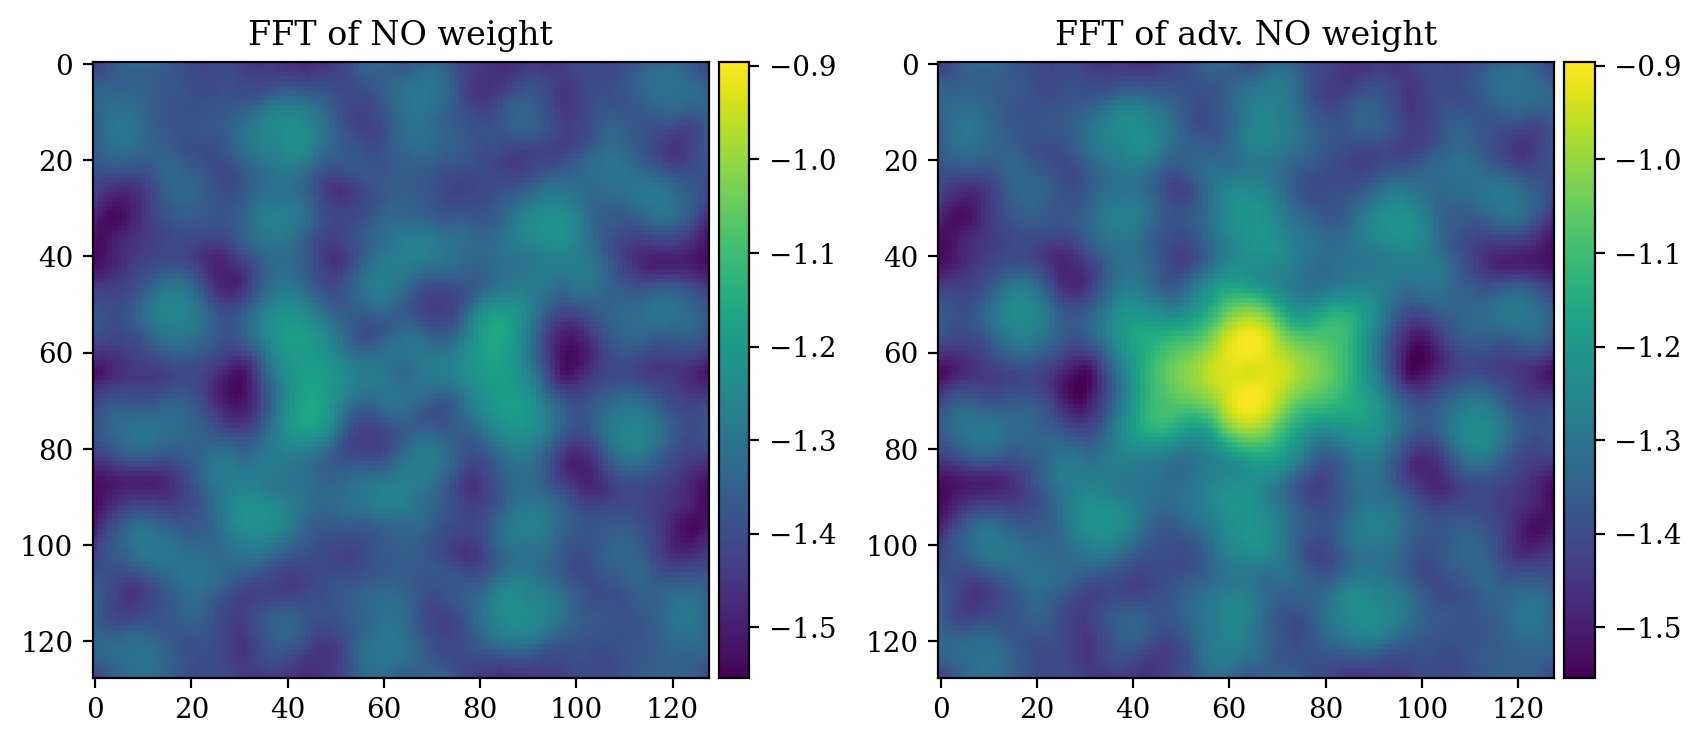

In [22]:

fft_no = torch.abs(torch.fft.fftshift(torch.fft.fftn(no_w, dim=(-1,-2), s=(128,128)))).detach().cpu().numpy()
fft_noadv = torch.abs(torch.fft.fftshift(torch.fft.fftn(noadv_w, dim=(-1,-2), s=(128,128)))).detach().cpu().numpy()

field1 = np.log(np.mean(fft_no, axis=0))
field2 = np.log(np.mean(fft_noadv, axis=0))

VMIN = min(np.min(field1), np.min(field2))
VMAX = max(np.max(field1), np.max(field2))
CMAP = "viridis"

fig, axes = plt.subplots(1,2, figsize=(10,4))
ax = axes[0]
im = ax.imshow(field1, cmap=CMAP, vmin=VMIN, vmax=VMAX)
ax.set_title("FFT of NO weight")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax = axes[1]
im = ax.imshow(field2, cmap=CMAP, vmin=VMIN, vmax=VMAX)
ax.set_title("FFT of adv. NO weight")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [23]:
np.min(fft_no), np.min(fft_noadv), np.max(fft_no), np.max(fft_noadv)

(0.0001648386, 0.0001399219, 0.88499784, 1.4557114)

In [24]:
for i in range(len(no_name_ls)):
    print(f"{no_name_ls[i]}: {no_param_ls[i].shape}")

init_conv.weight: torch.Size([16, 4, 7, 7])
time_mlp.1.weight: torch.Size([64, 16])
time_mlp.3.weight: torch.Size([64, 64])
downs.0.0.mlp.1.weight: torch.Size([32, 64])
downs.0.0.block1.proj.weight: torch.Size([16, 16, 3, 3])
downs.0.0.block2.proj.weight: torch.Size([16, 16, 3, 3])
downs.0.1.mlp.1.weight: torch.Size([32, 64])
downs.0.1.block1.proj.weight: torch.Size([16, 16, 3, 3])
downs.0.1.block2.proj.weight: torch.Size([16, 16, 3, 3])
downs.0.2.fn.fn.to_qkv.weight: torch.Size([384, 16, 1, 1])
downs.0.2.fn.fn.to_out.0.weight: torch.Size([16, 128, 1, 1])
downs.0.3.1.weight: torch.Size([16, 64, 1, 1])
downs.1.0.mlp.1.weight: torch.Size([32, 64])
downs.1.0.block1.proj.weight: torch.Size([16, 16, 3, 3])
downs.1.0.block2.proj.weight: torch.Size([16, 16, 3, 3])
downs.1.1.mlp.1.weight: torch.Size([32, 64])
downs.1.1.block1.proj.weight: torch.Size([16, 16, 3, 3])
downs.1.1.block2.proj.weight: torch.Size([16, 16, 3, 3])
downs.1.2.fn.fn.to_qkv.weight: torch.Size([384, 16, 1, 1])
downs.1.2.fn.f

init_conv.weight: torch.Size([16, 4, 7, 7])


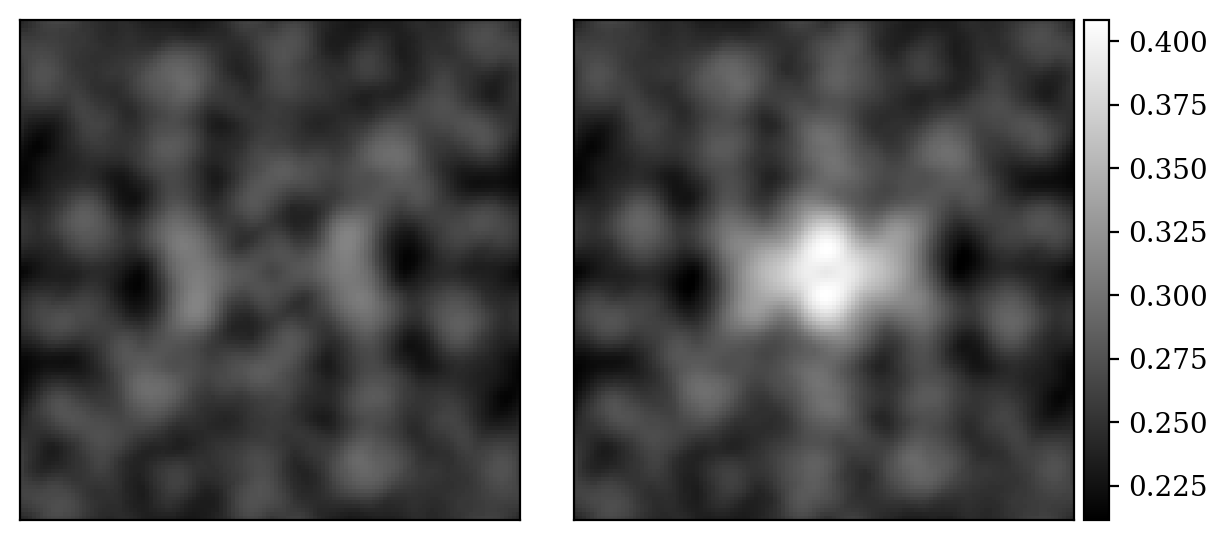

downs.0.0.block1.proj.weight: torch.Size([16, 16, 3, 3])


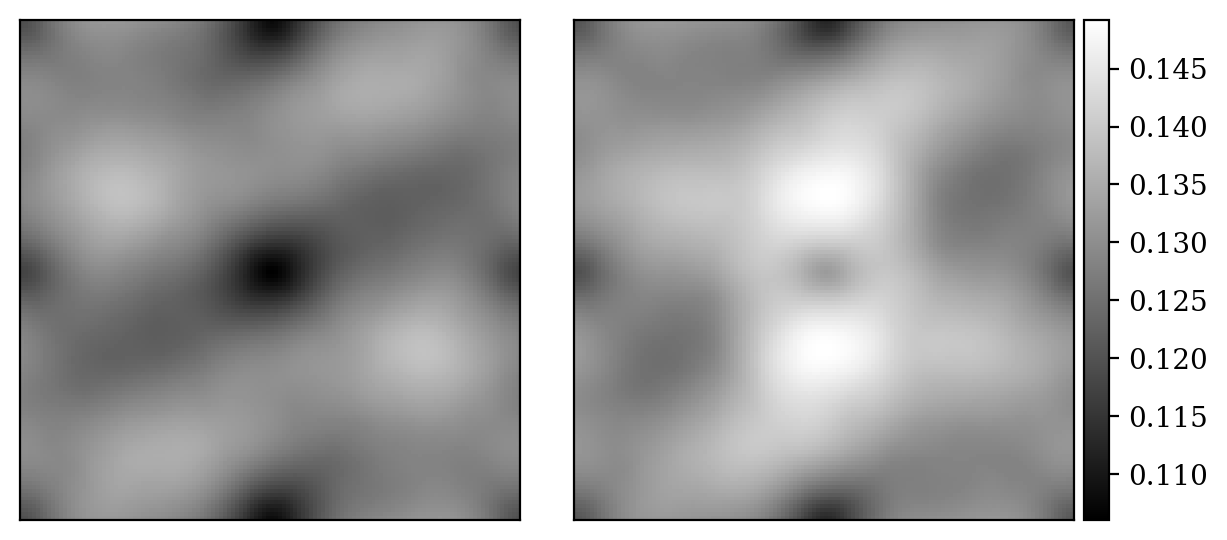

downs.0.0.block2.proj.weight: torch.Size([16, 16, 3, 3])


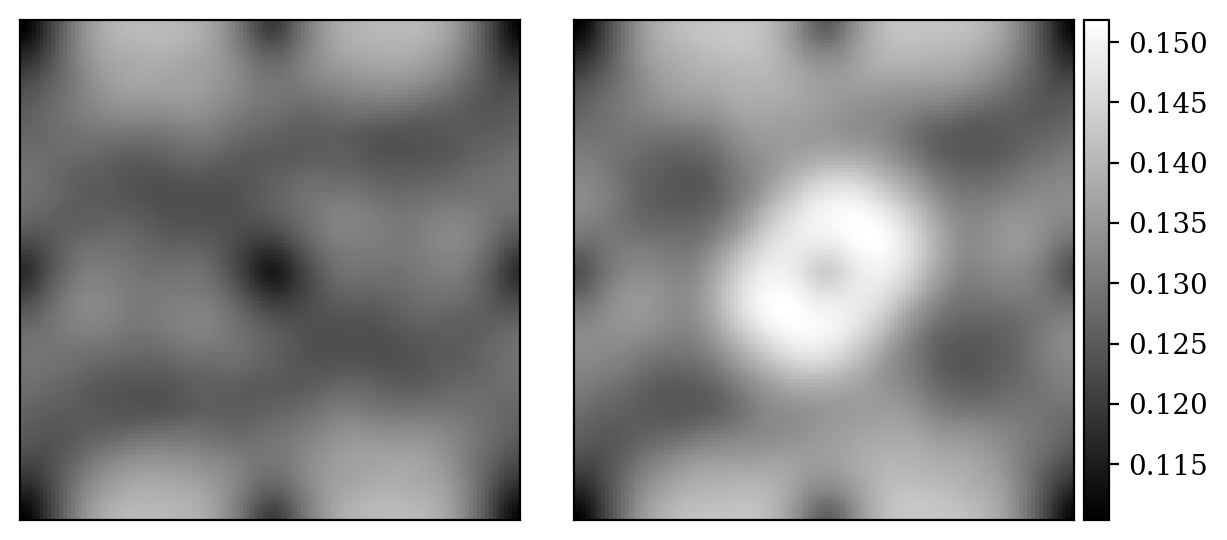

downs.0.1.block1.proj.weight: torch.Size([16, 16, 3, 3])


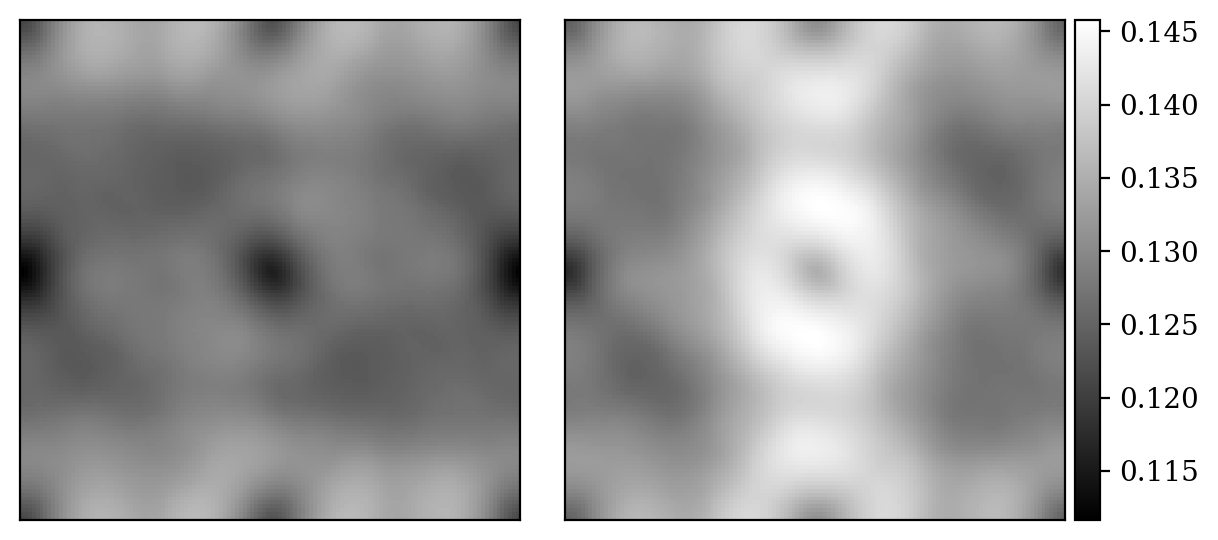

downs.0.1.block2.proj.weight: torch.Size([16, 16, 3, 3])


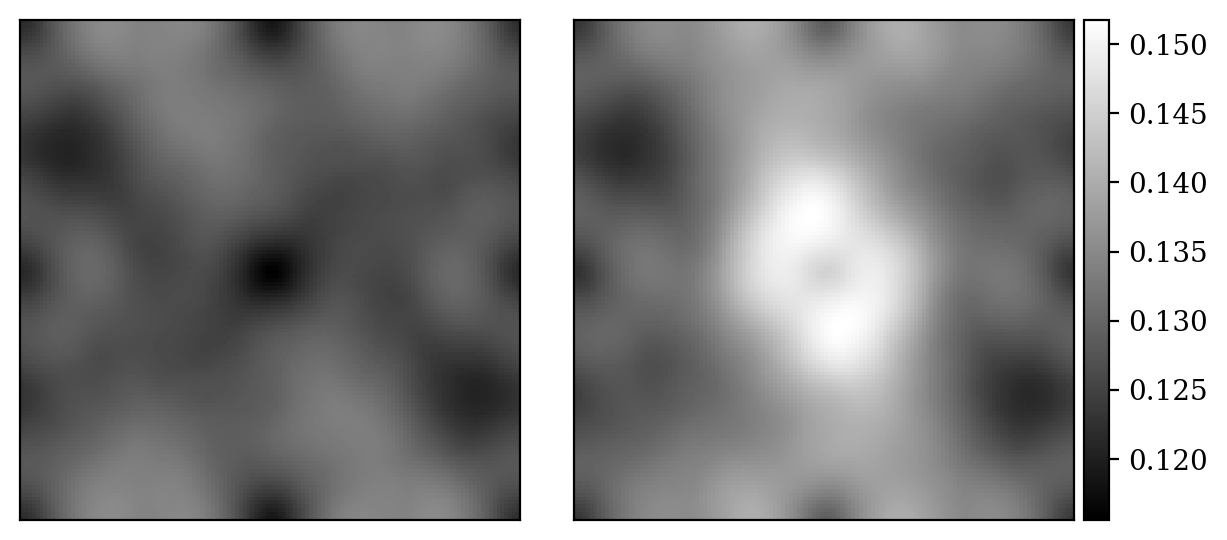

downs.1.0.block1.proj.weight: torch.Size([16, 16, 3, 3])


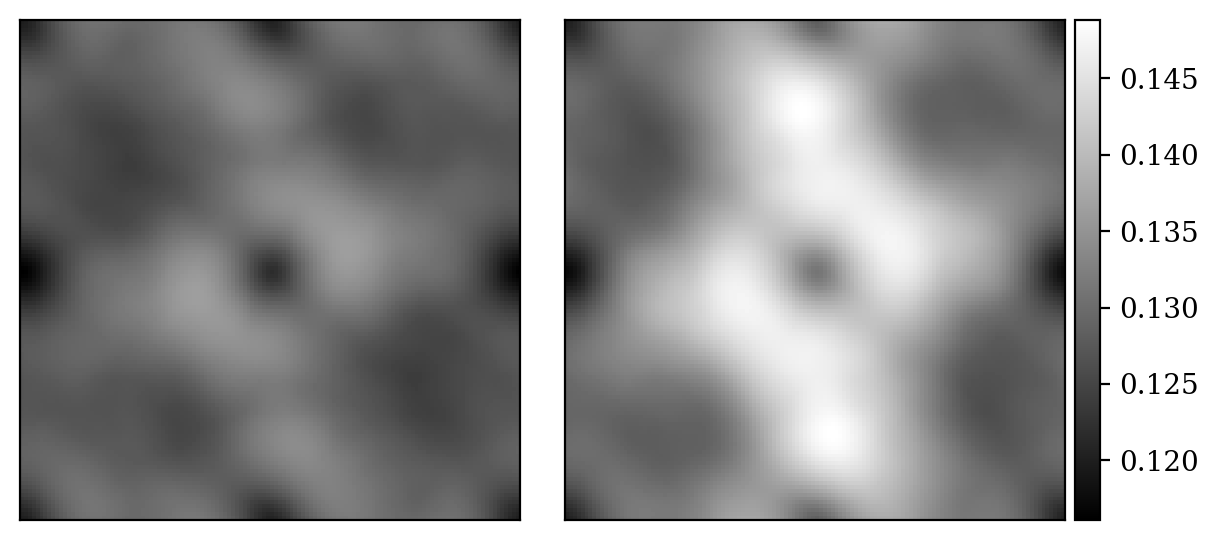

downs.1.0.block2.proj.weight: torch.Size([16, 16, 3, 3])


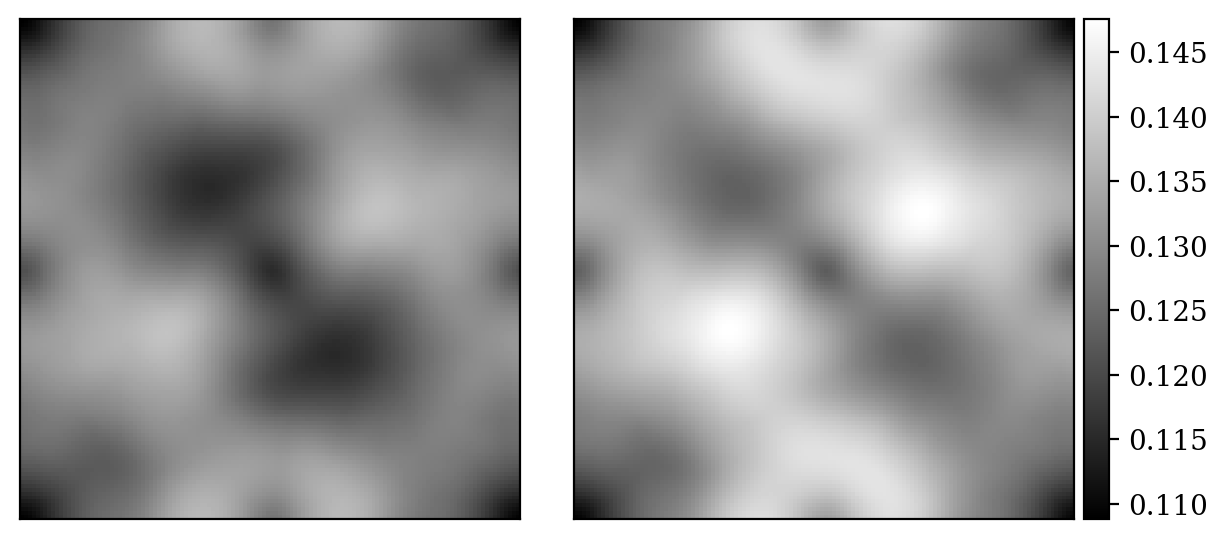

downs.1.1.block1.proj.weight: torch.Size([16, 16, 3, 3])


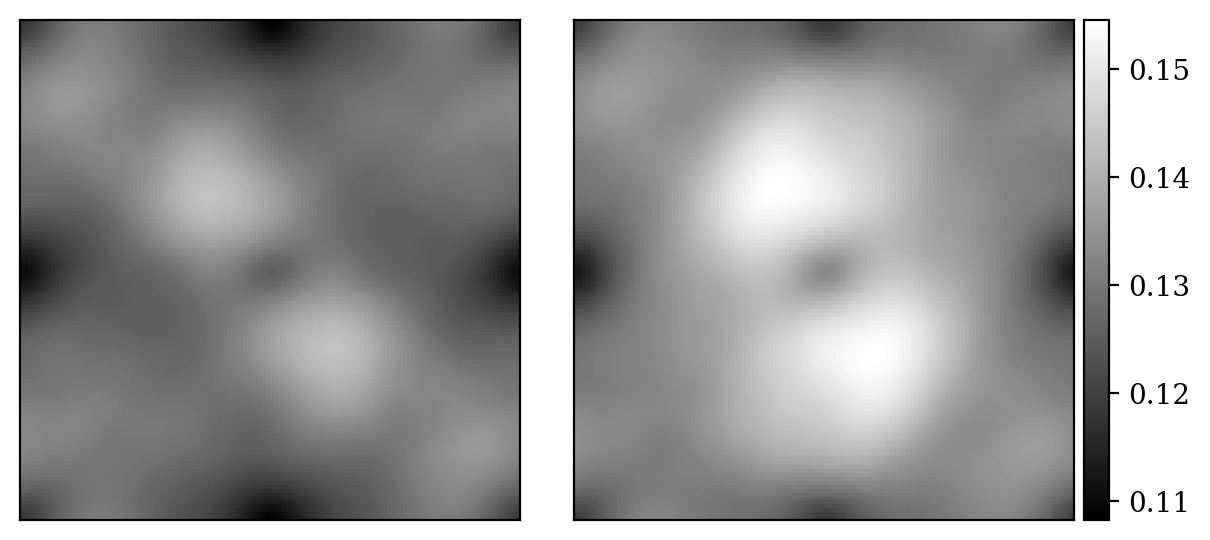

downs.1.1.block2.proj.weight: torch.Size([16, 16, 3, 3])


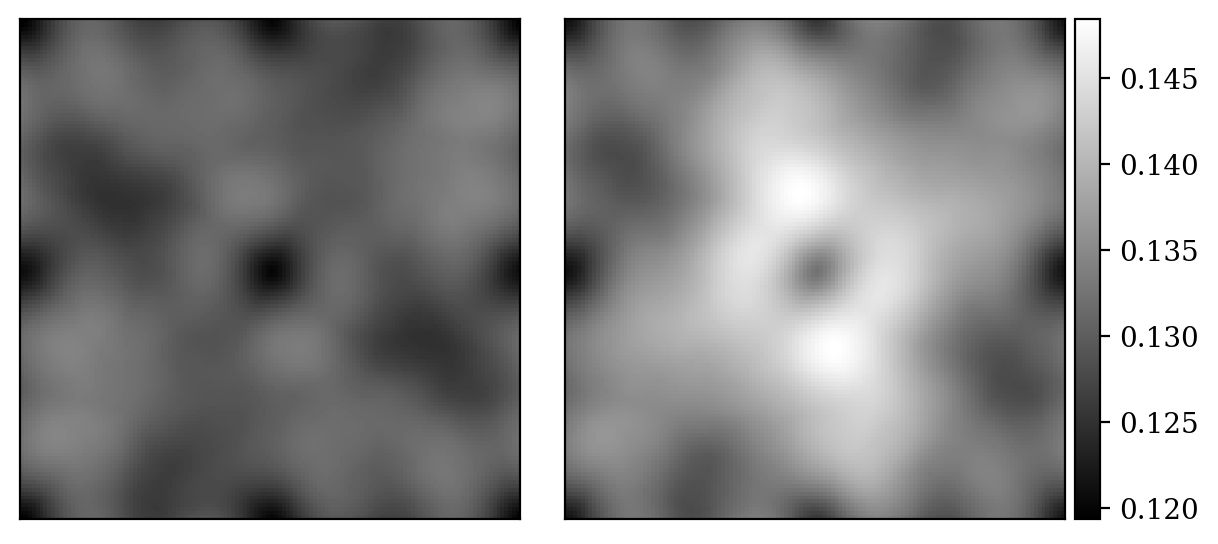

downs.2.0.block1.proj.weight: torch.Size([32, 32, 3, 3])


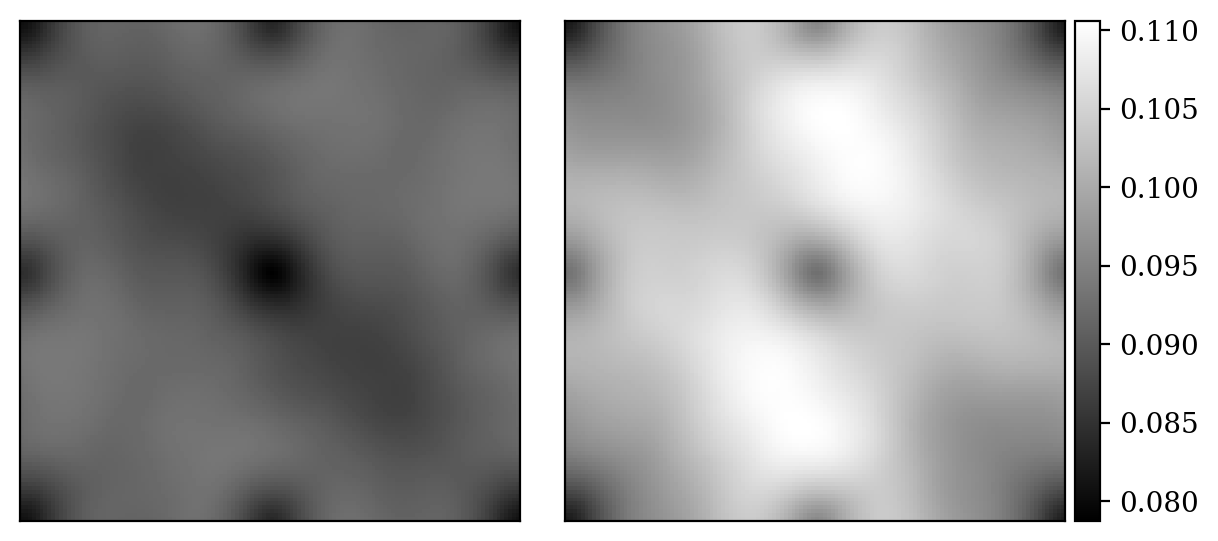

downs.2.0.block2.proj.weight: torch.Size([32, 32, 3, 3])


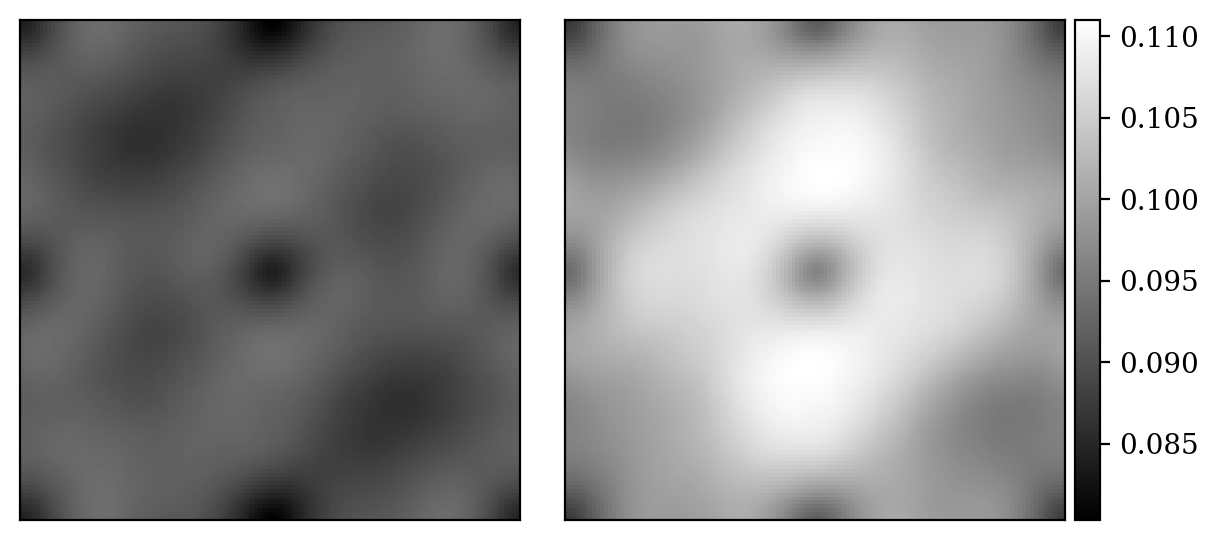

downs.2.1.block1.proj.weight: torch.Size([32, 32, 3, 3])


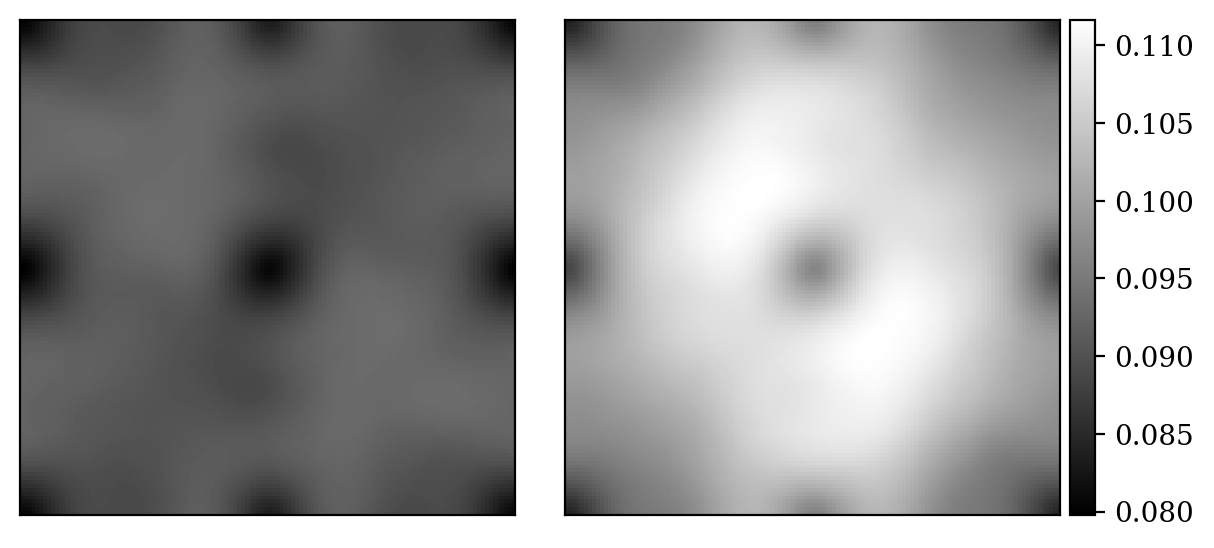

downs.2.1.block2.proj.weight: torch.Size([32, 32, 3, 3])


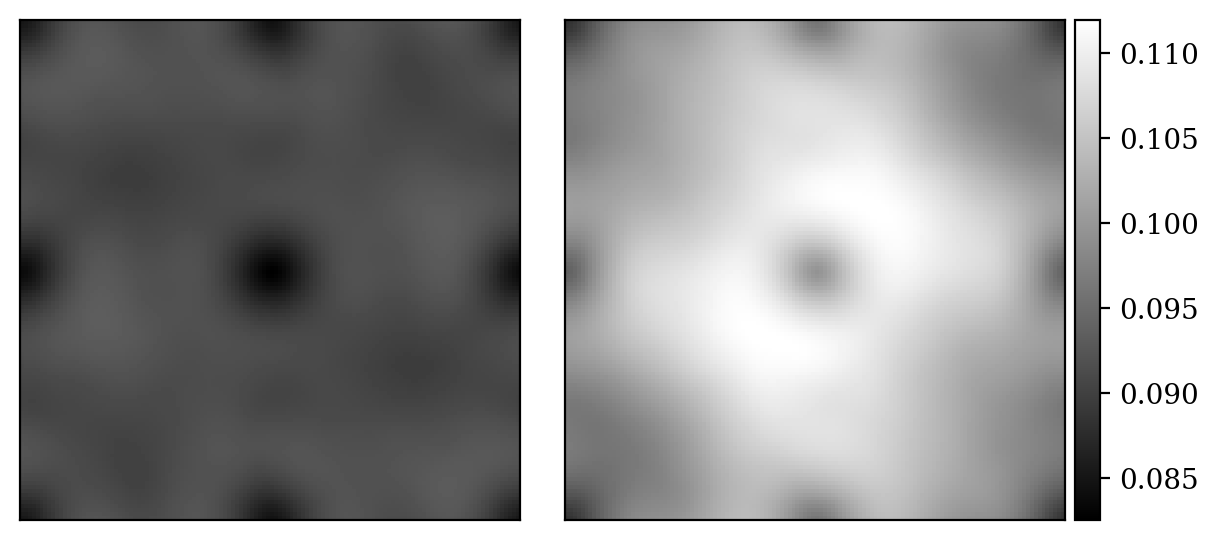

downs.3.0.block1.proj.weight: torch.Size([64, 64, 3, 3])


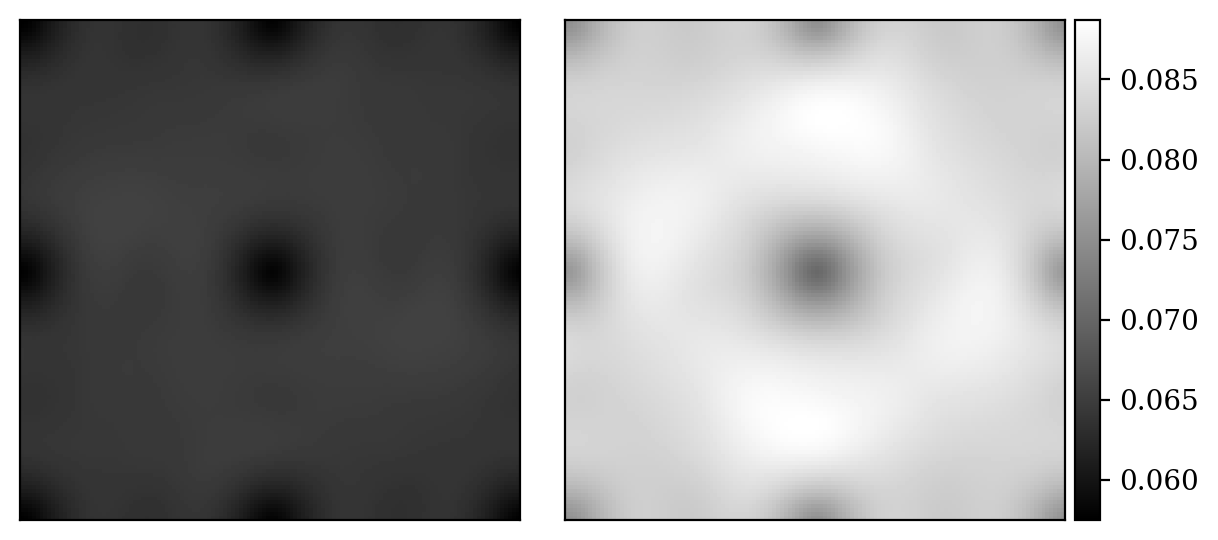

downs.3.0.block2.proj.weight: torch.Size([64, 64, 3, 3])


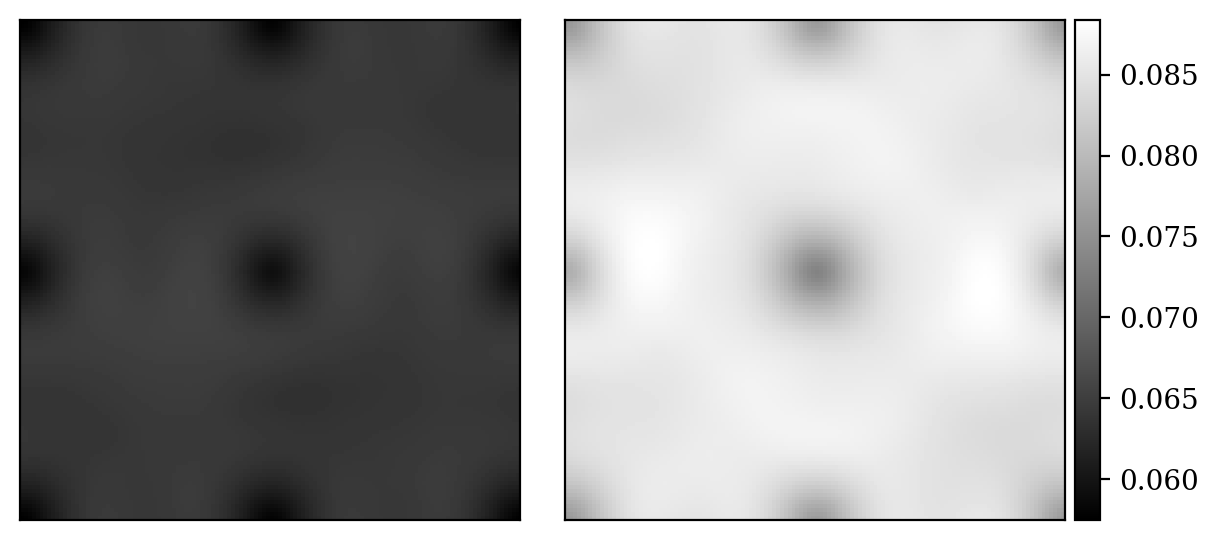

downs.3.1.block1.proj.weight: torch.Size([64, 64, 3, 3])


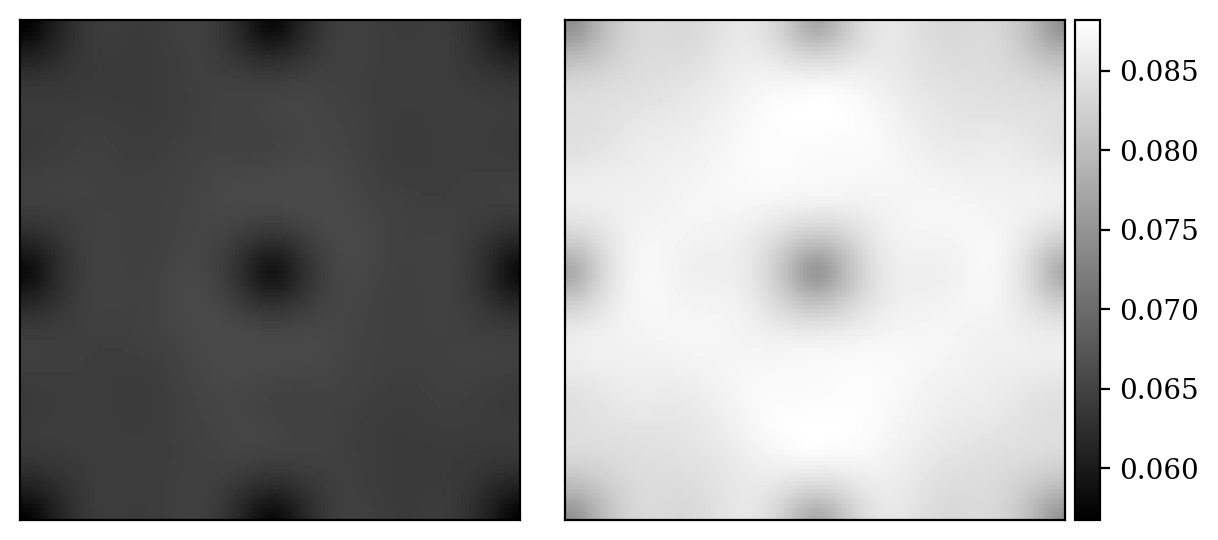

downs.3.1.block2.proj.weight: torch.Size([64, 64, 3, 3])


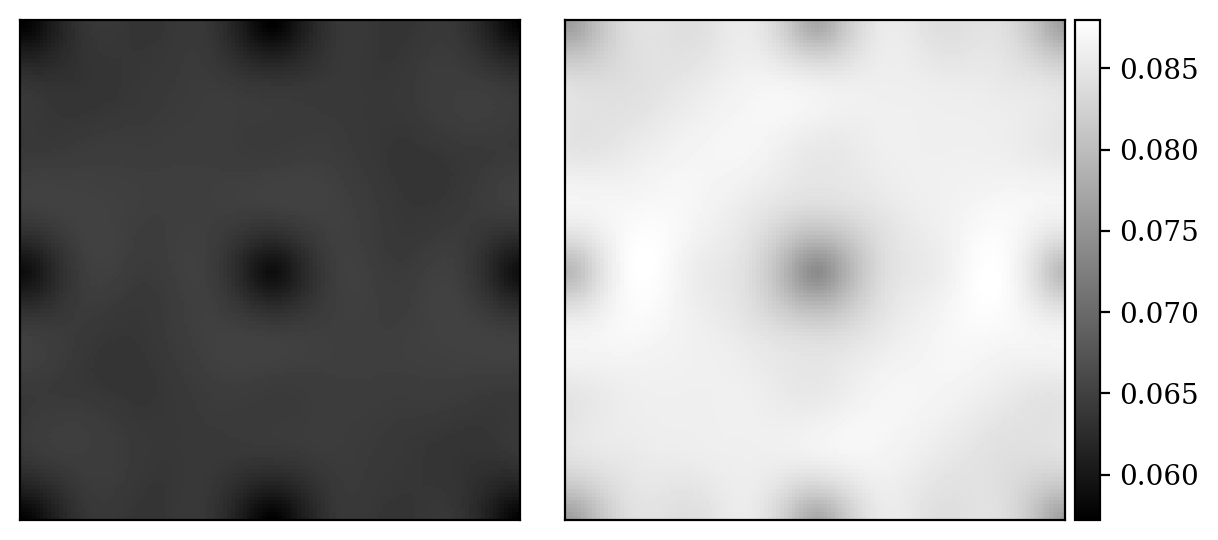

downs.3.3.weight: torch.Size([128, 64, 3, 3])


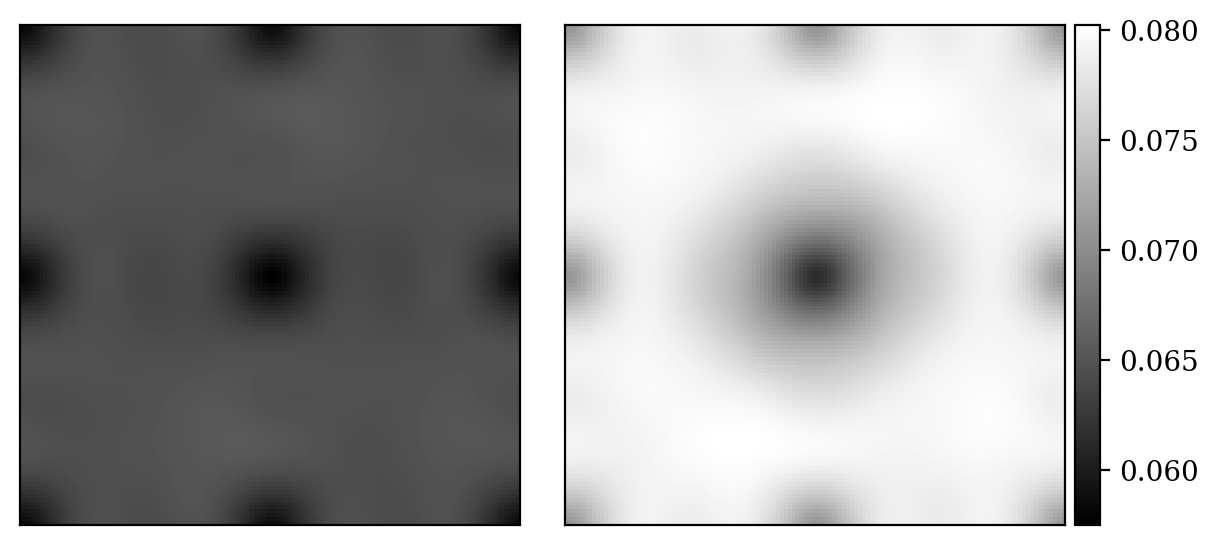

ups.0.0.block1.proj.weight: torch.Size([128, 192, 3, 3])


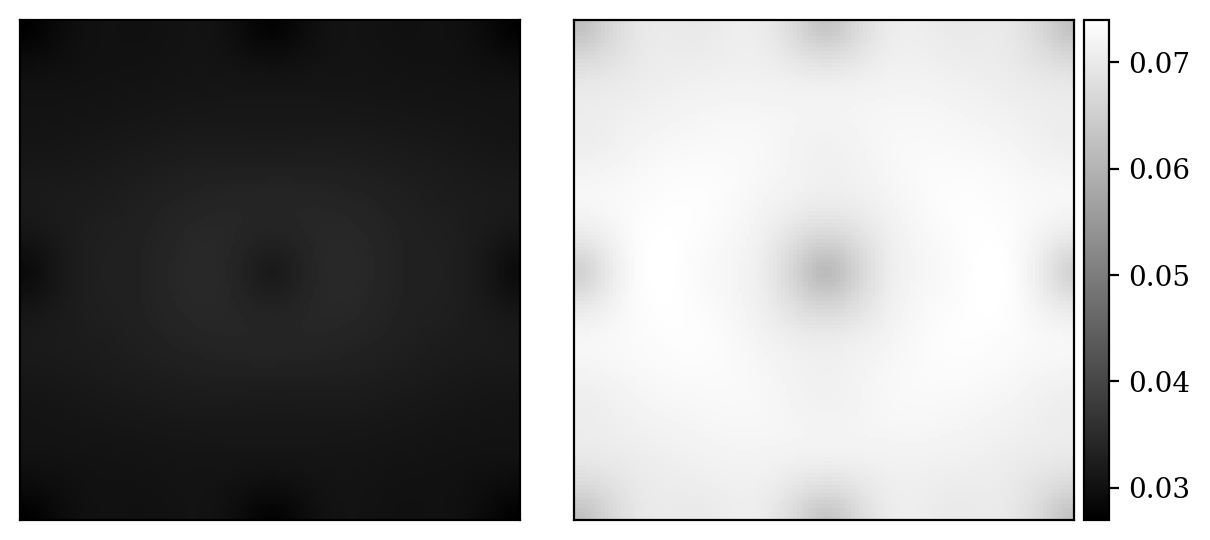

ups.0.0.block2.proj.weight: torch.Size([128, 128, 3, 3])


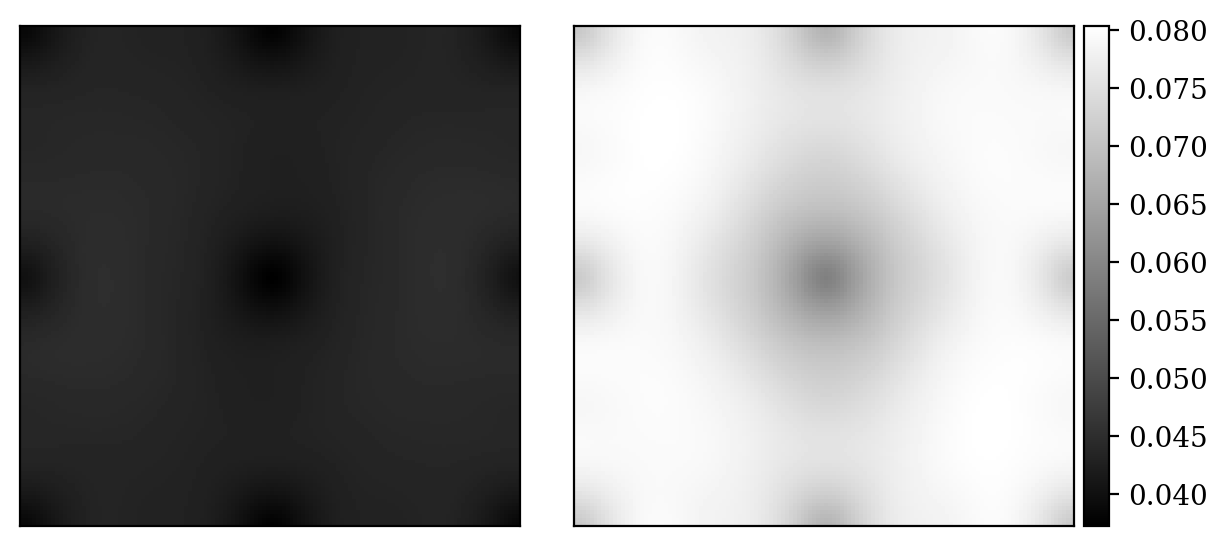

ups.0.1.block1.proj.weight: torch.Size([128, 192, 3, 3])


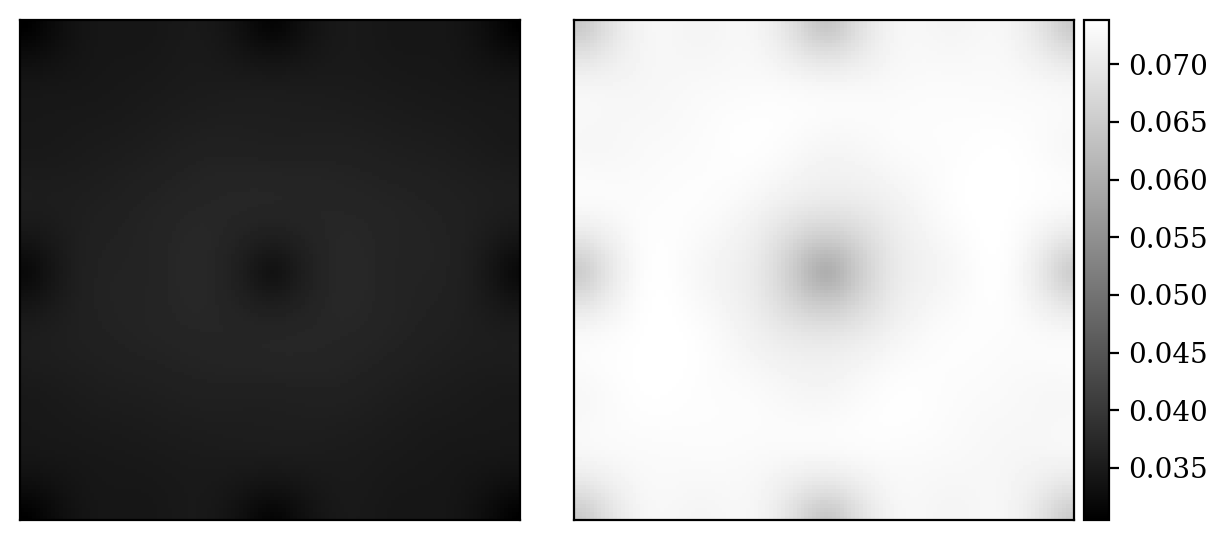

ups.0.1.block2.proj.weight: torch.Size([128, 128, 3, 3])


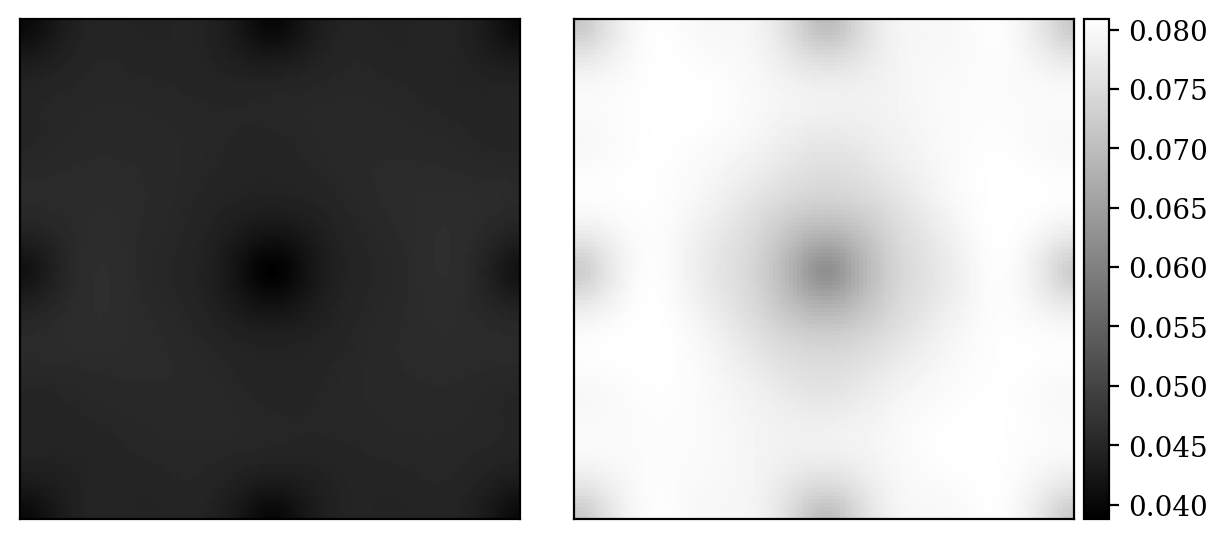

ups.0.3.1.weight: torch.Size([64, 128, 3, 3])


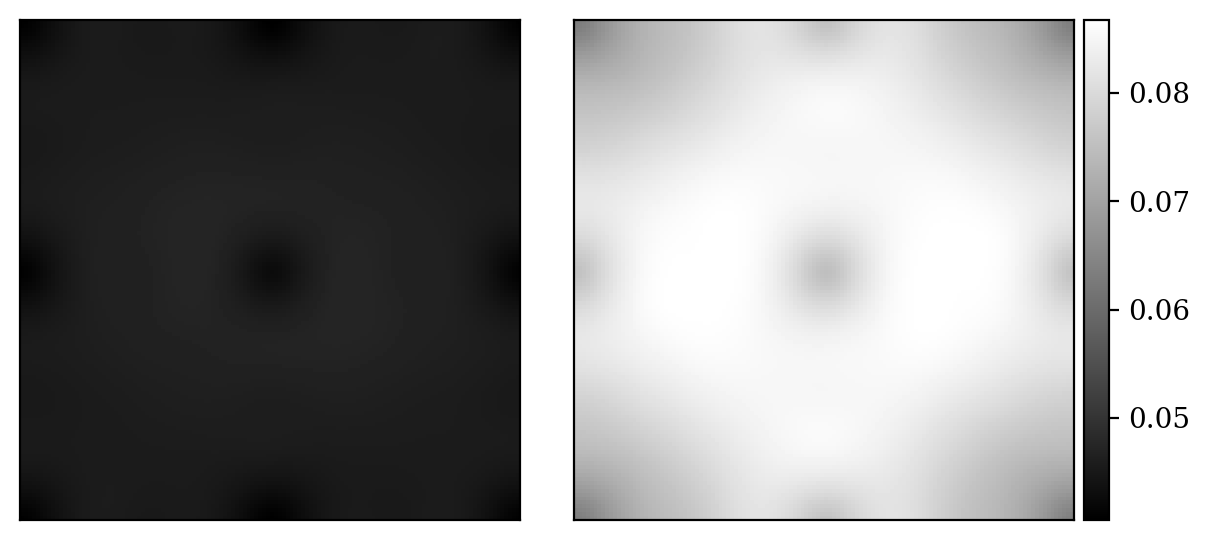

ups.1.0.block1.proj.weight: torch.Size([64, 96, 3, 3])


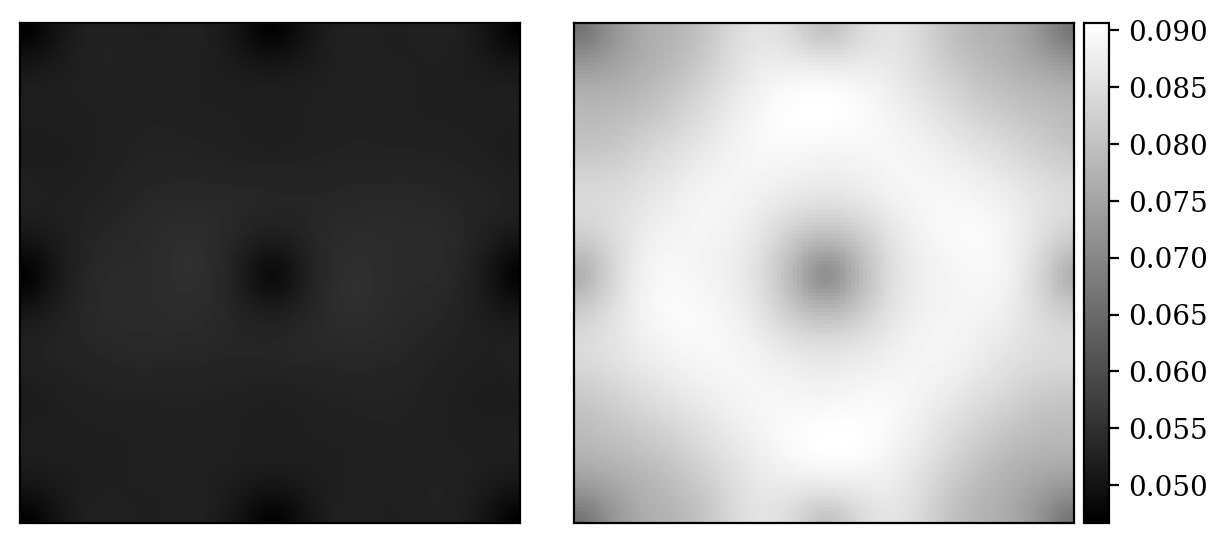

ups.1.0.block2.proj.weight: torch.Size([64, 64, 3, 3])


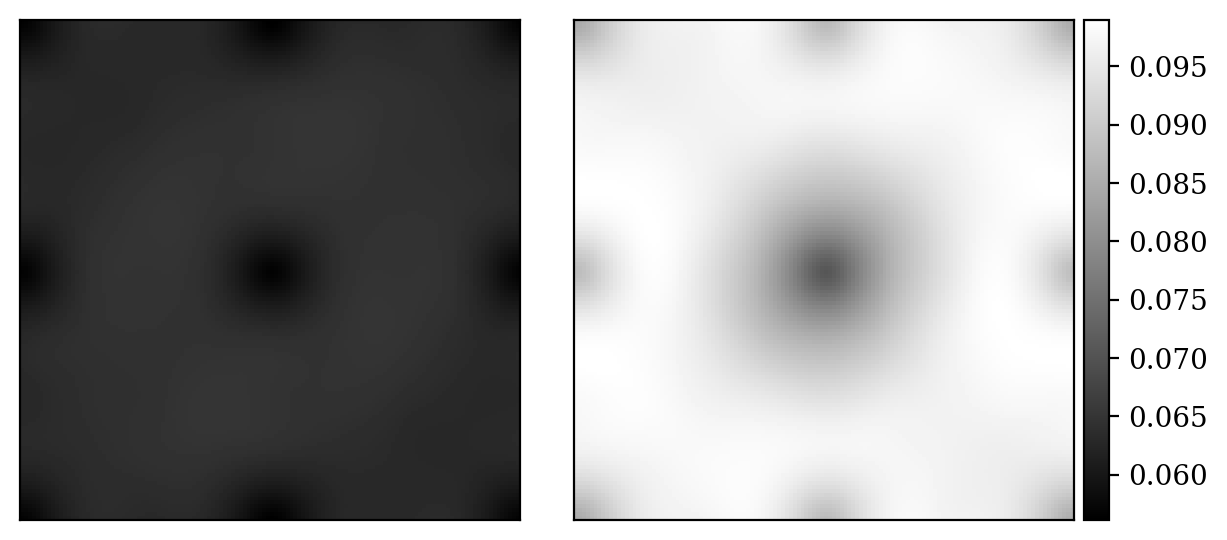

ups.1.1.block1.proj.weight: torch.Size([64, 96, 3, 3])


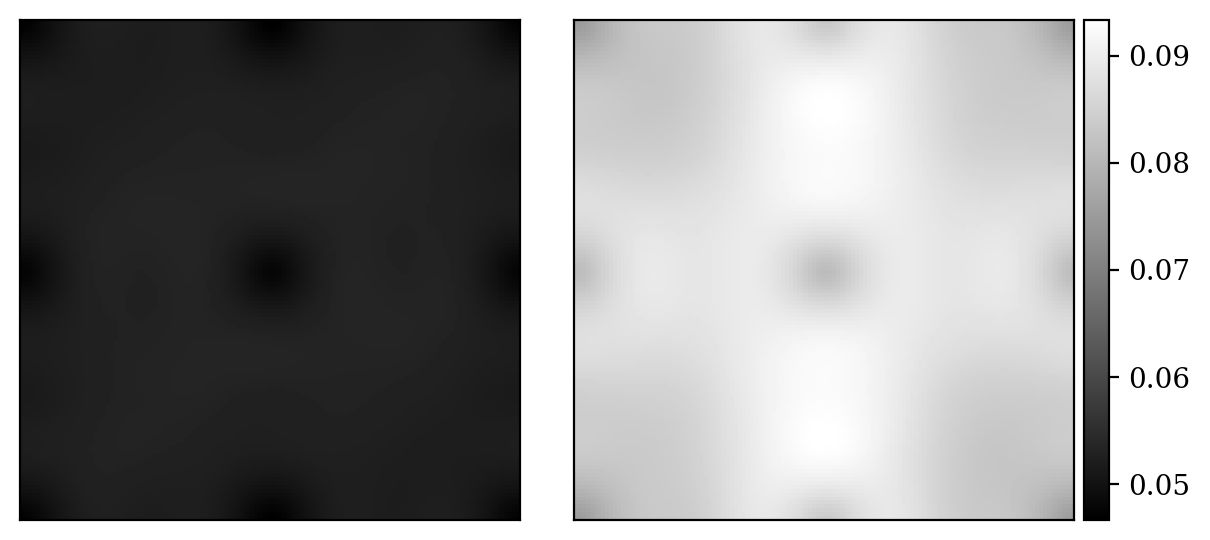

ups.1.1.block2.proj.weight: torch.Size([64, 64, 3, 3])


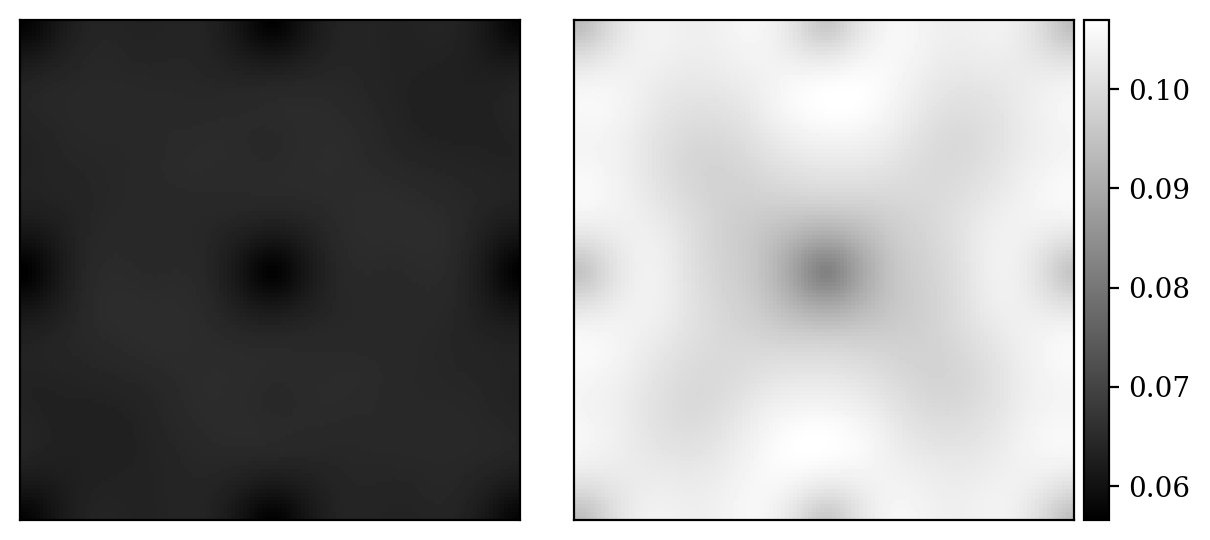

ups.1.3.1.weight: torch.Size([32, 64, 3, 3])


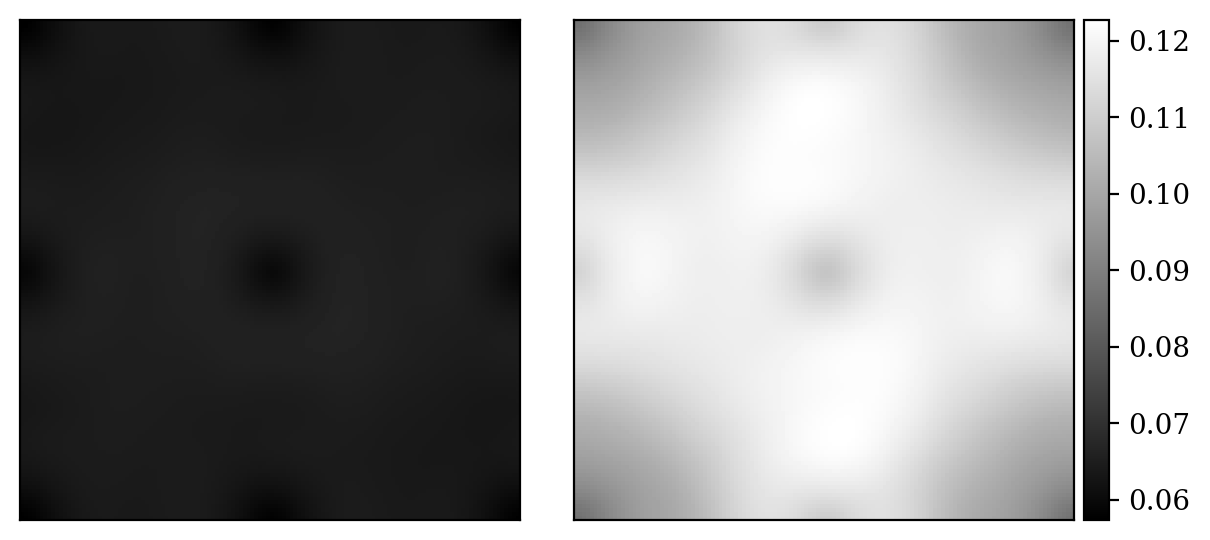

ups.2.0.block1.proj.weight: torch.Size([32, 48, 3, 3])


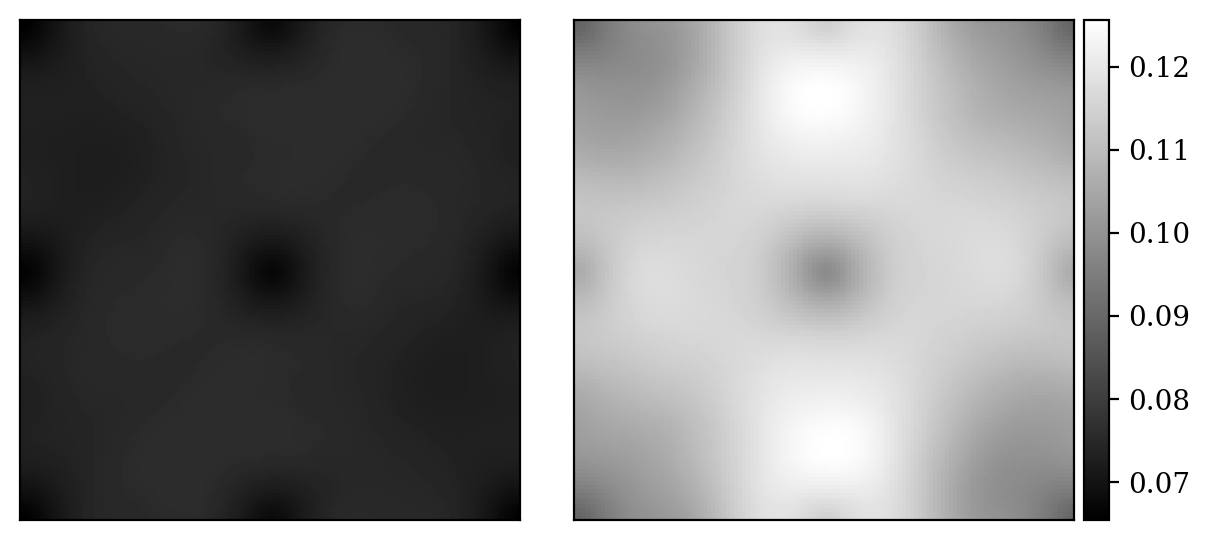

ups.2.0.block2.proj.weight: torch.Size([32, 32, 3, 3])


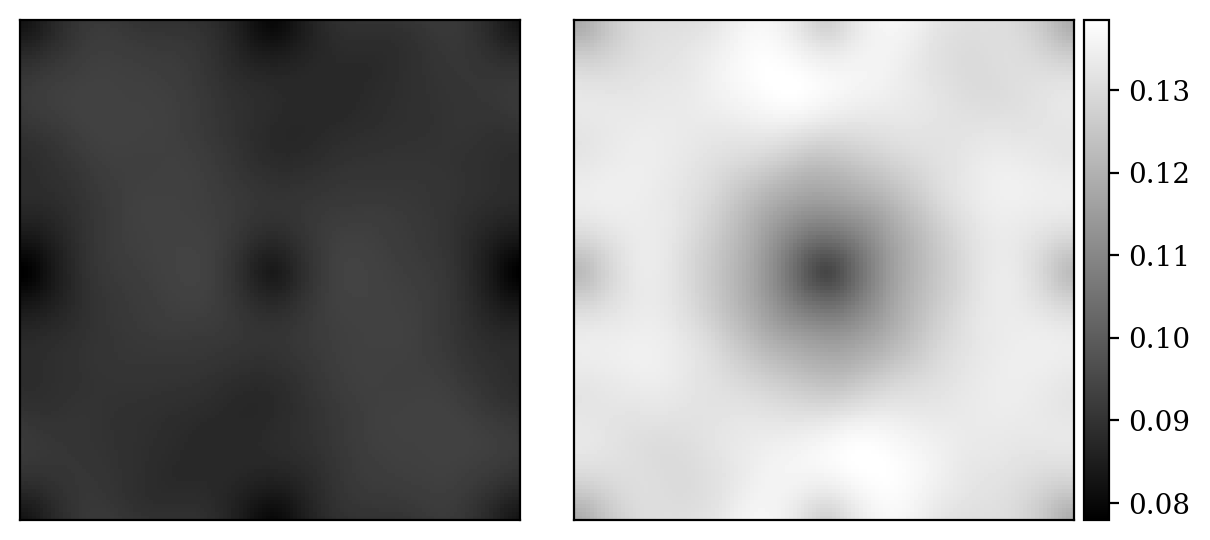

ups.2.1.block1.proj.weight: torch.Size([32, 48, 3, 3])


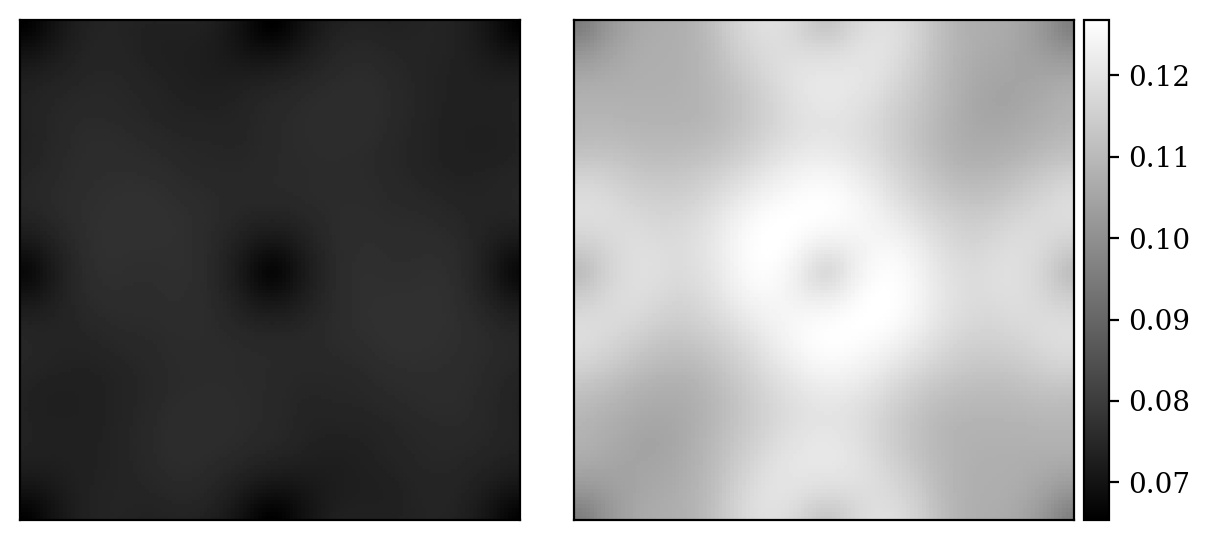

ups.2.1.block2.proj.weight: torch.Size([32, 32, 3, 3])


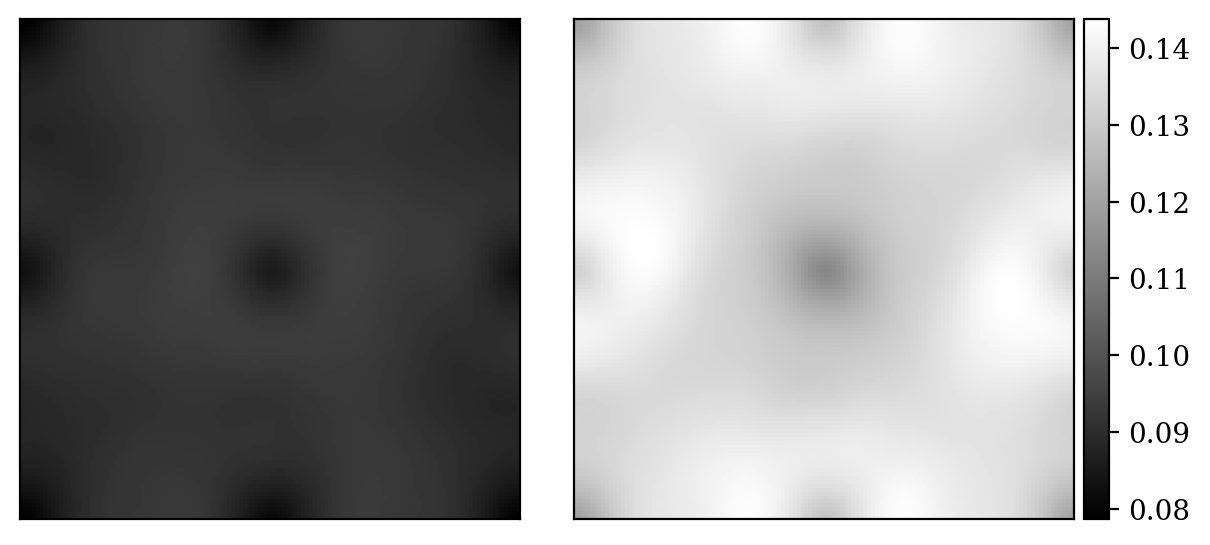

ups.2.3.1.weight: torch.Size([16, 32, 3, 3])


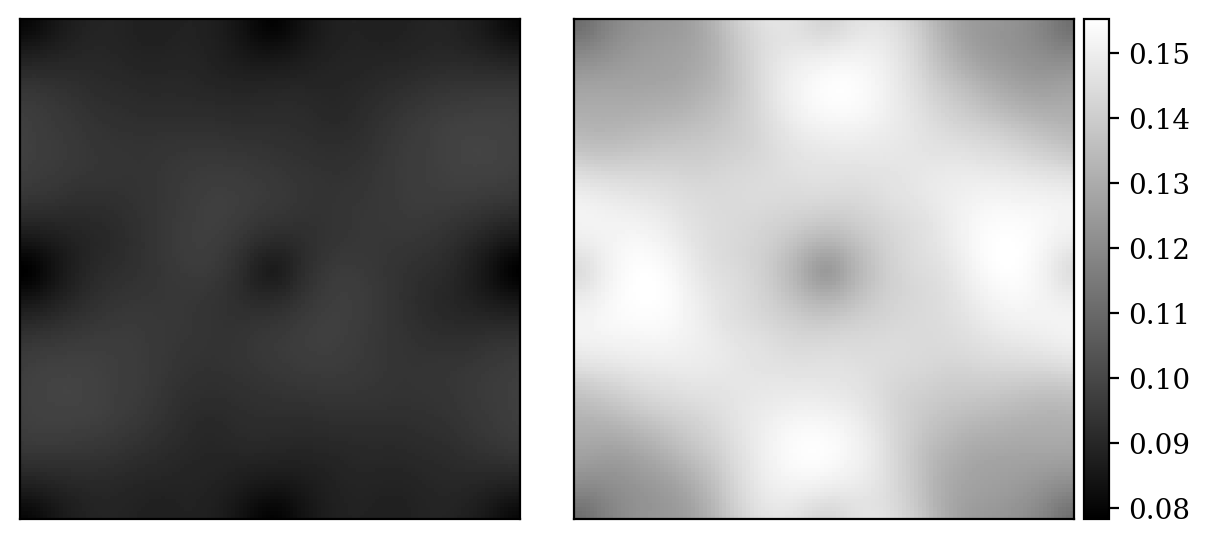

ups.3.0.block1.proj.weight: torch.Size([16, 32, 3, 3])


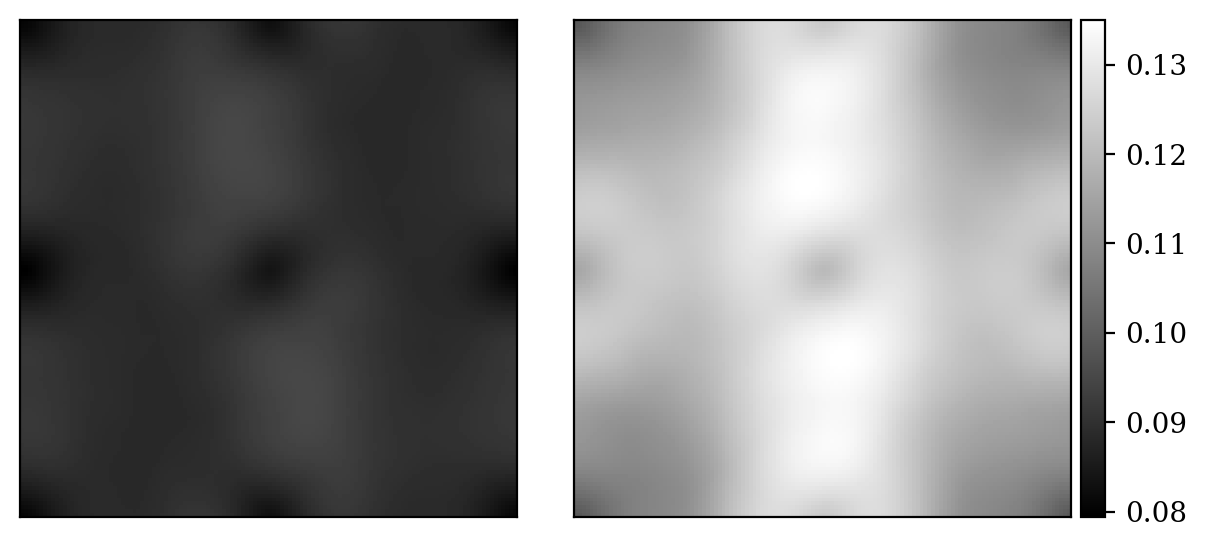

ups.3.0.block2.proj.weight: torch.Size([16, 16, 3, 3])


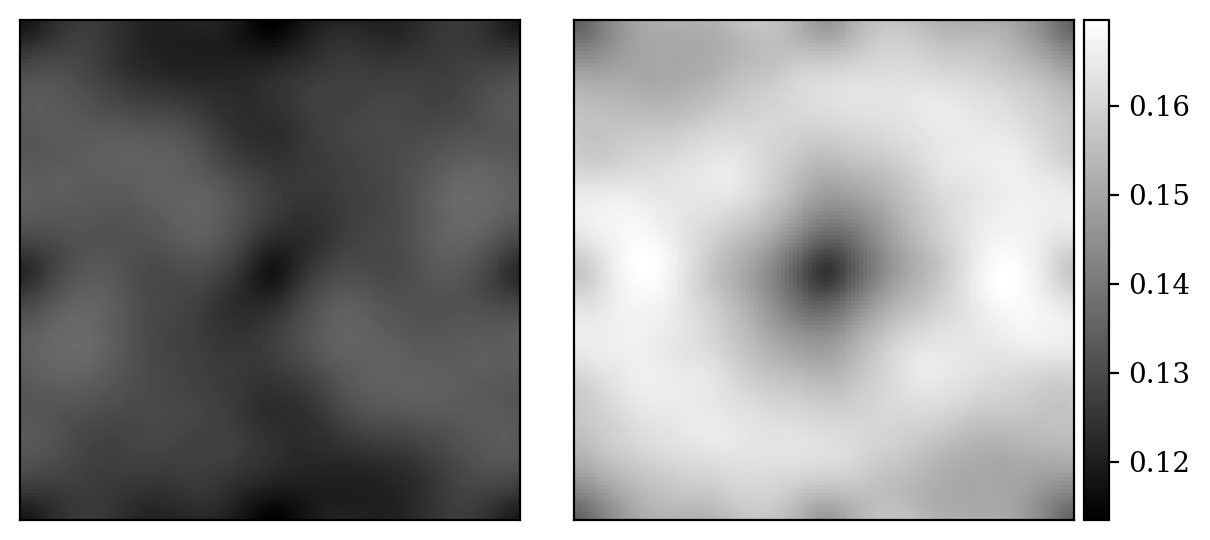

ups.3.1.block1.proj.weight: torch.Size([16, 32, 3, 3])


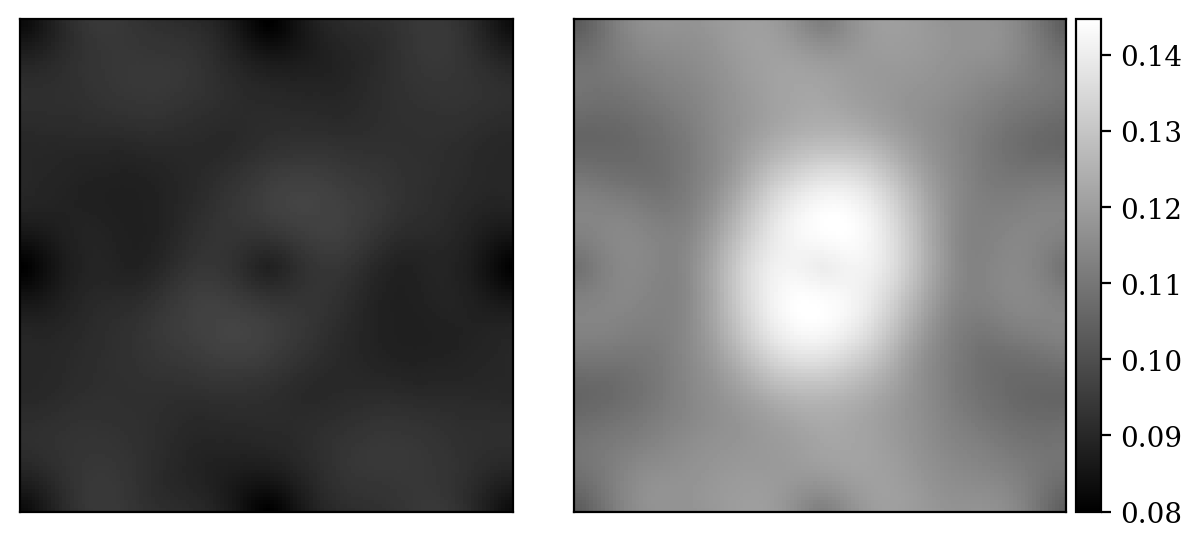

ups.3.1.block2.proj.weight: torch.Size([16, 16, 3, 3])


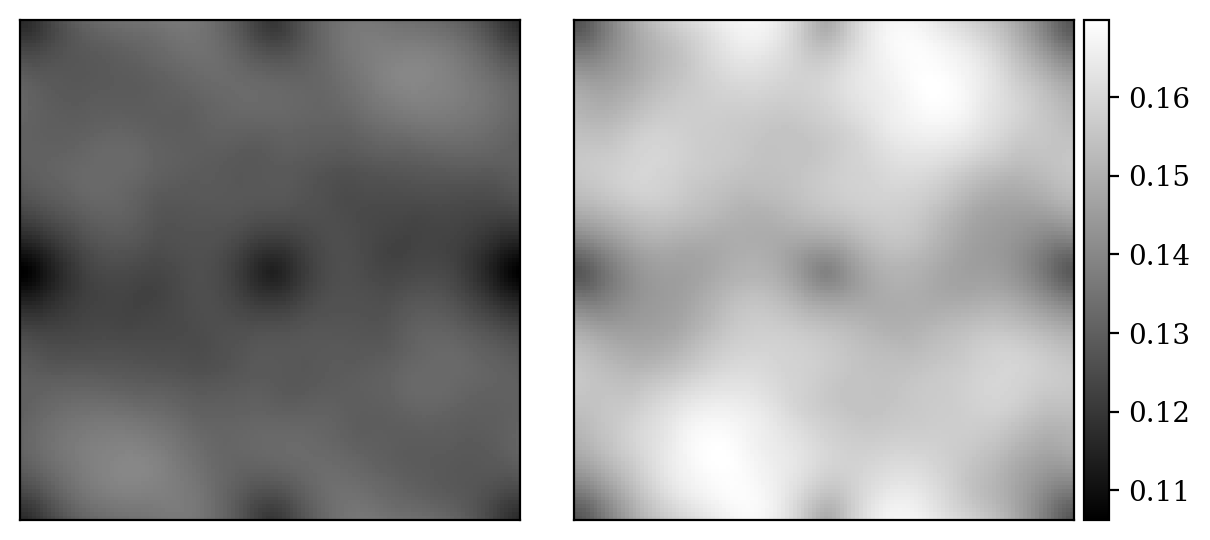

ups.3.3.weight: torch.Size([16, 16, 3, 3])


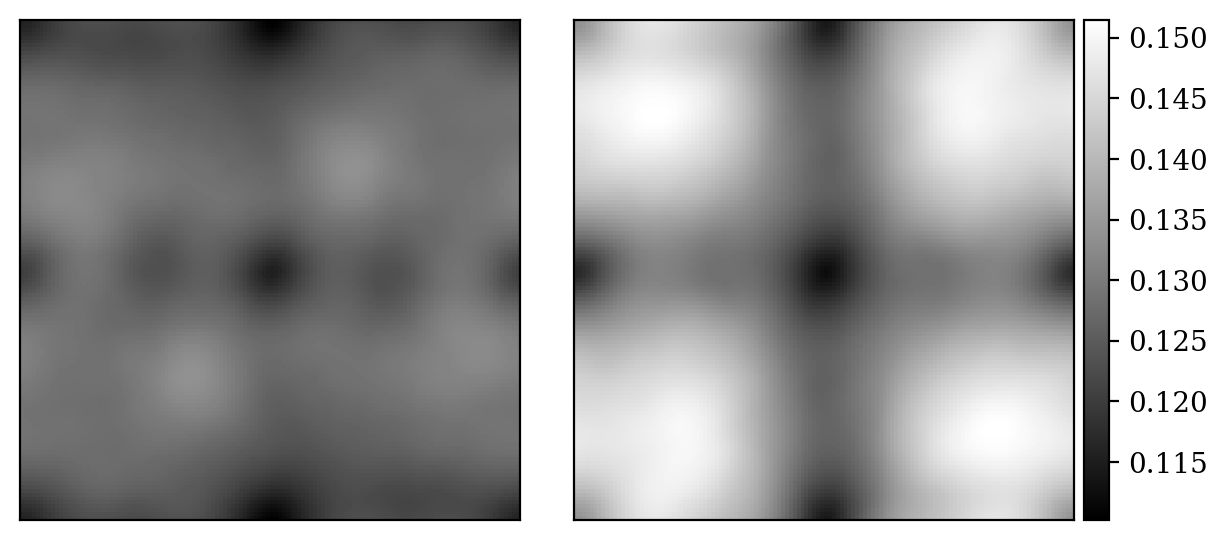

mid_block1.block1.proj.weight: torch.Size([128, 128, 3, 3])


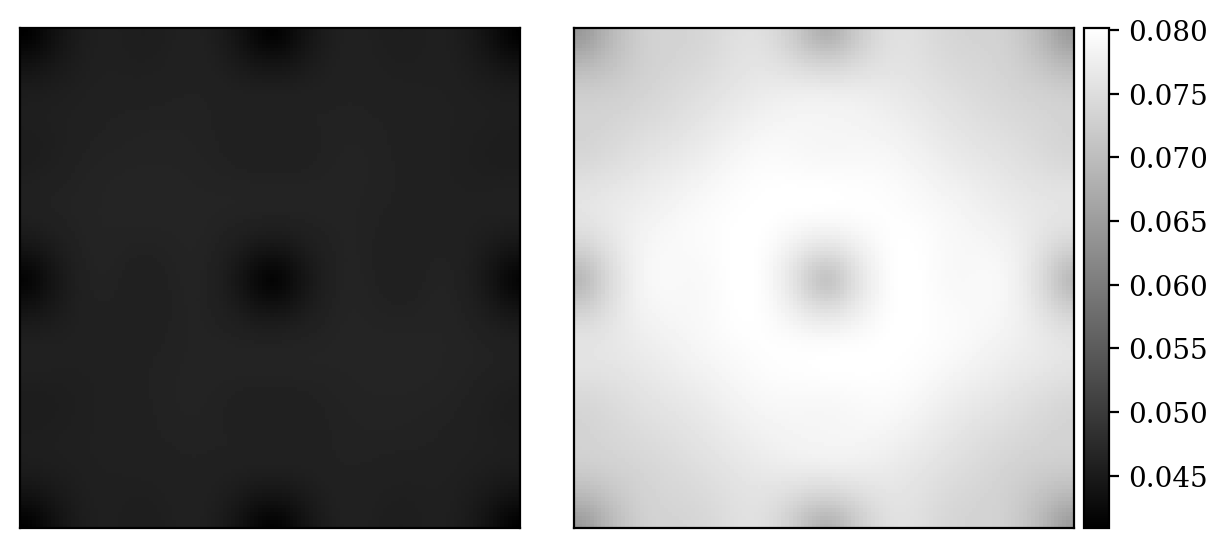

mid_block1.block2.proj.weight: torch.Size([128, 128, 3, 3])


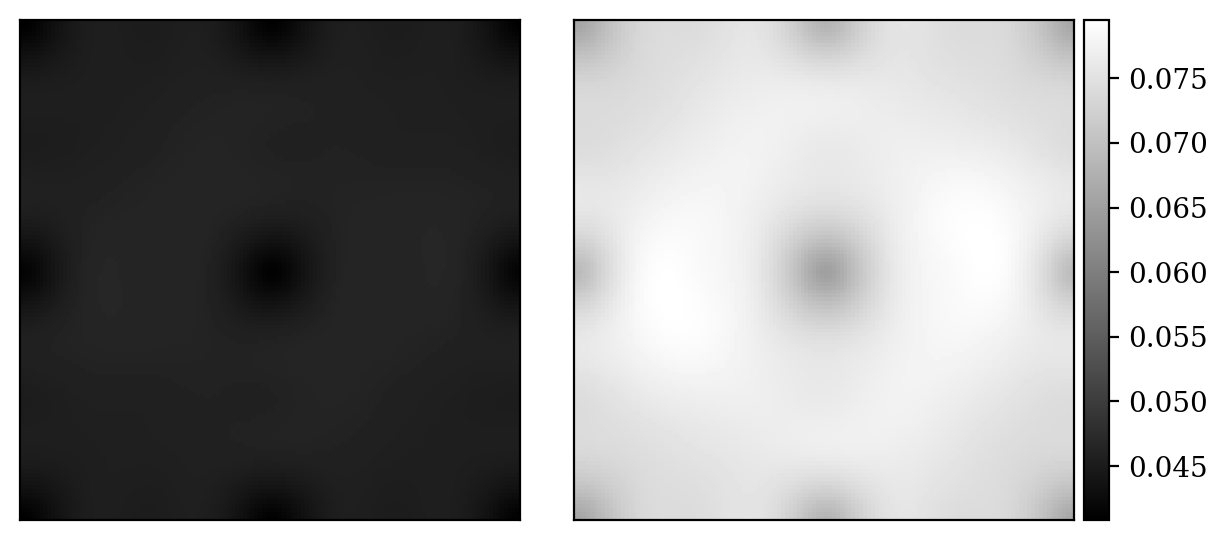

mid_block2.block1.proj.weight: torch.Size([128, 128, 3, 3])


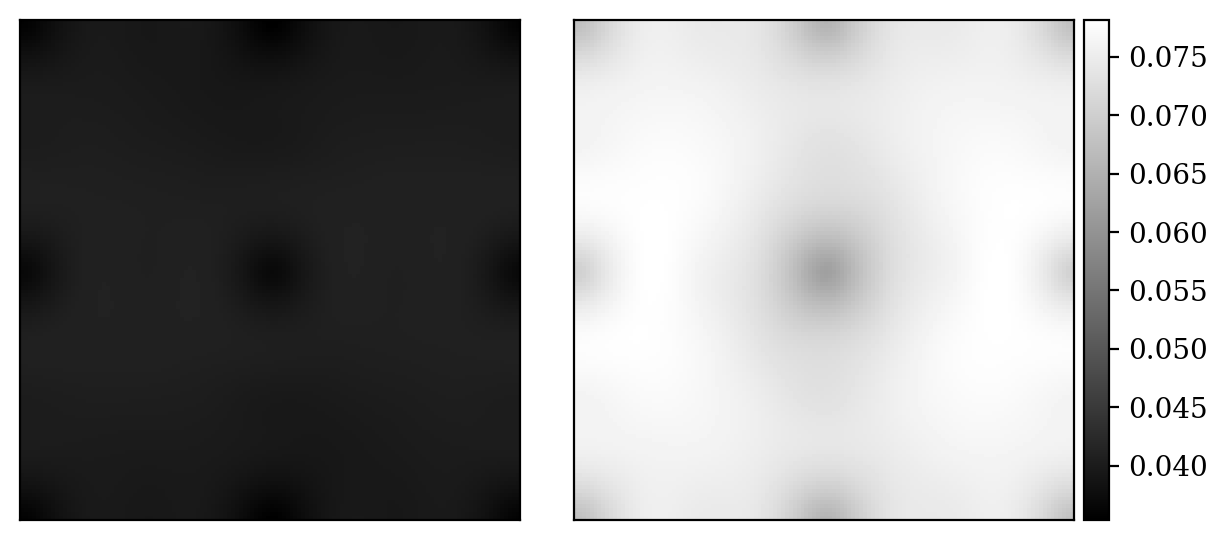

mid_block2.block2.proj.weight: torch.Size([128, 128, 3, 3])


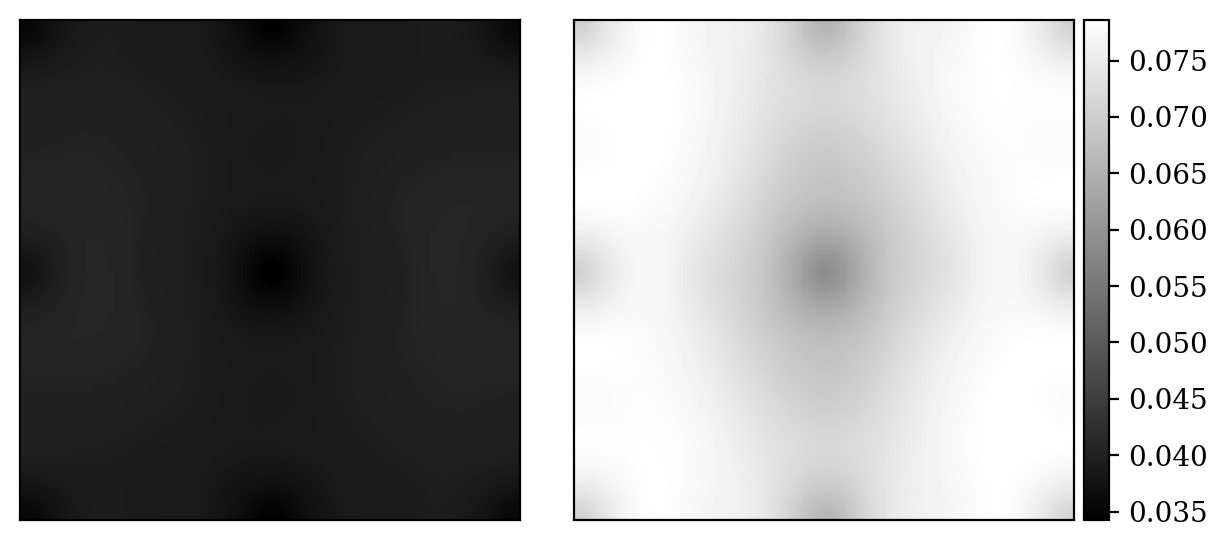

final_res_block.block1.proj.weight: torch.Size([16, 32, 3, 3])


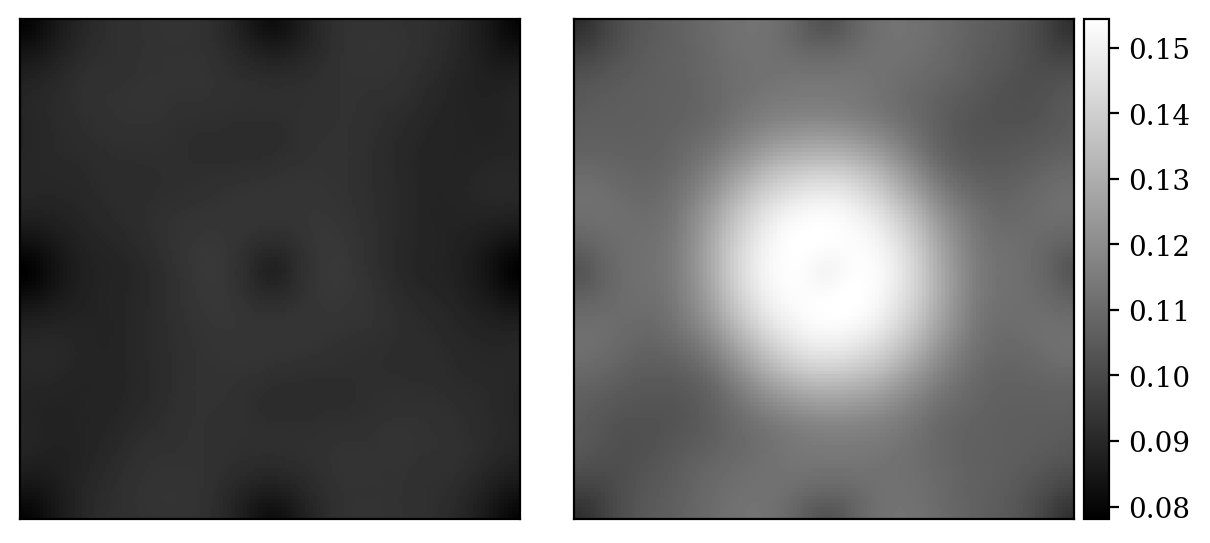

final_res_block.block2.proj.weight: torch.Size([16, 16, 3, 3])


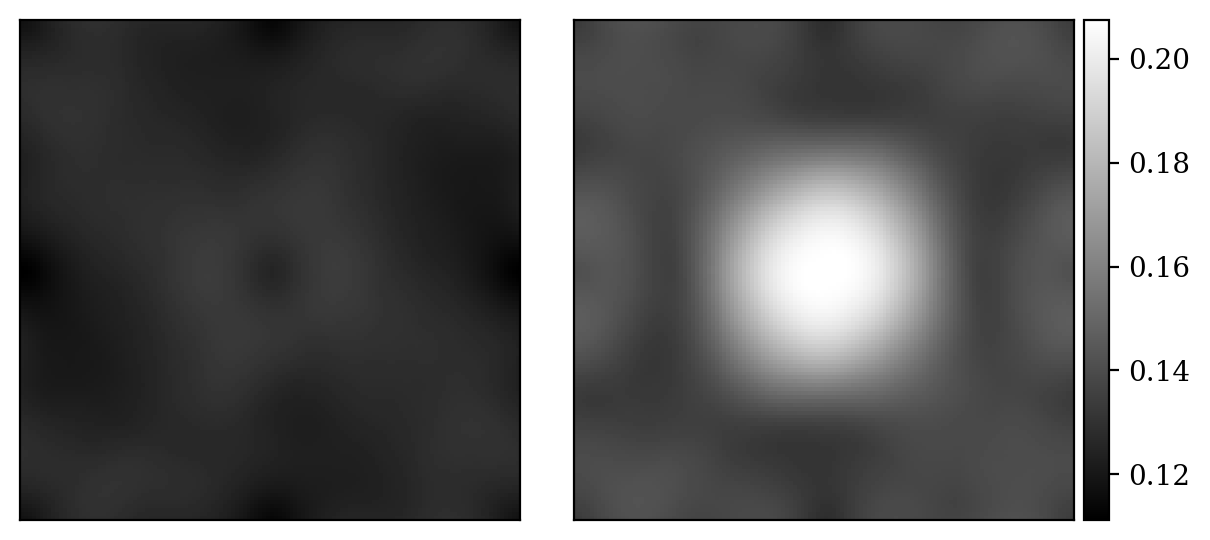

In [32]:
for i in range(len(no_name_ls)):
    
    if len(no_param_ls[i].shape)==4 and no_param_ls[i].shape[-1] != 1:
        ic, oc, kx, ky = no_param_ls[i].shape
        no_w = no_param_ls[i].reshape(-1, kx, ky)
        noadv_w = noadv_param_ls[i].reshape(-1, kx, ky)
        
        print(f"{no_name_ls[i]}: {no_param_ls[i].shape}")
        
        fft_no = torch.abs(torch.fft.fftshift(torch.fft.fftn(no_w, dim=(-1,-2), s=(128,128)))).detach().cpu().numpy()
        fft_noadv = torch.abs(torch.fft.fftshift(torch.fft.fftn(noadv_w, dim=(-1,-2), s=(128,128)))).detach().cpu().numpy()
        
        field1 = (np.mean(fft_no, axis=0))
        field2 = (np.mean(fft_noadv, axis=0))
        
        VMIN = min(np.min(field1), np.min(field2))
        VMAX = max(np.max(field1), np.max(field2))
        CMAP = "gray"
        
        fig, axes = plt.subplots(1,2, figsize=(9*0.7,4*0.7))
        ax = axes[0]
        im = ax.imshow(field1, cmap=CMAP, vmin=VMIN, vmax=VMAX)
        # ax.set_title("FFT of NO weight")
        divider = make_axes_locatable(ax)
        # cax = divider.append_axes('right', size='5%', pad=0.05)
        # fig.colorbar(im, cax=cax, orientation='vertical')
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax = axes[1]
        im = ax.imshow(field2, cmap=CMAP, vmin=VMIN, vmax=VMAX)
        # ax.set_title("FFT of adv. NO weight")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax.set_xticks([])
        ax.set_yticks([])

        fig.tight_layout()
        
        plt.show()